# 1.Callibration

Reading Calibration images
Callibration images read


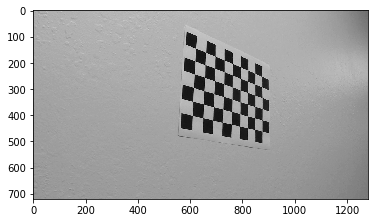

In [25]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

#In this part we will be reading the callibration images
#and preparing the object and image points.

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

print("Reading Calibration images")
# Make a list of calibration images
images = glob.glob("C:/Users/Dan/Desktop/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/camera_cal/calibration*.jpg")

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, plt.gray())
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
     


print("Callibration images read")

 Undistort 

In this part we will undistort the checkerboard images. 

(1280, 720)


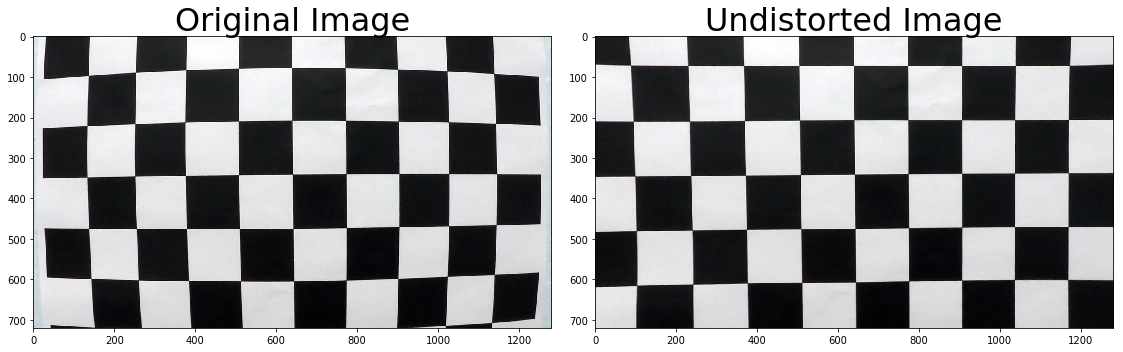

In [26]:
# Read in an image
img = cv2.imread("camera_cal/calibration1.jpg")
img_size = (img.shape[1], img.shape[0])
print(img_size)

#plt.imshow(img) 
#plt.show()

# Function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return mtx, dist, undist

mtx, dist, undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=32)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=32)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


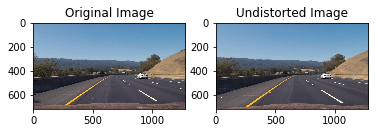

In [27]:
# more undistort examples
img = cv2.imread("test_images/test3.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mtx, dist, img2 = cal_undistort(imgRGB, objpoints, imgpoints) 
plt.subplot(2,2,1)
plt.title('Original Image')
fig = plt.imshow(imgRGB)
plt.imsave("C:\\orig.bmp",imgRGB)
plt.subplot(2,2,2)
plt.title('Undistorted Image')
fig = plt.imshow(img2)
plt.imsave("C:\\undist.bmp",img2)

# 2.IPM

[[  585.           460.        ]
 [  203.33332825   720.        ]
 [ 1141.66662598   720.        ]
 [  705.           460.        ]]
[[ 300.    0.]
 [ 330.  710.]
 [ 960.  710.]
 [ 960.    0.]]
720
1280


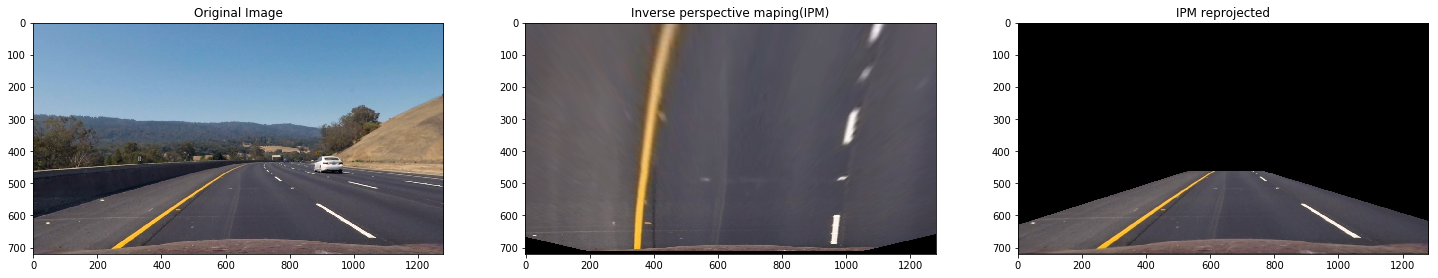

In [28]:
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 75, img_size[1]],
    [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])

print(src)
    
dst = np.float32([[300, 0], [330, 710], [960,710], [960, 0]])
print(dst)

img_height = 720#img_size[0]
img_width = 1280#img_size[1]
print(img_height)
print(img_width)

        
M = cv2.getPerspectiveTransform(src, dst) # get matrix to project from perspective > IPM
Minv = cv2.getPerspectiveTransform(dst, src) # get matrix to project from IPM > perspective

# warp images (generate IPM and the back to perspective from IPM)
ipm = cv2.warpPerspective(img2, M, img_size, flags=cv2.INTER_LINEAR) # INTER_CUBIC is much slower
img_unpersp = cv2.warpPerspective(ipm, Minv, img_size, flags=cv2.INTER_LINEAR)

# show results
plt.figure(figsize=(25,15))

plt.subplot(3,3,1)
plt.title('Original Image')
fig = plt.imshow(img2)

plt.subplot(3,3,2)
plt.title('Inverse perspective maping(IPM)')
fig = plt.imshow(ipm)

plt.subplot(3,3,3)
plt.title('IPM reprojected')
fig = plt.imshow(img_unpersp)

# 3. Find lane points

Midpoint:  640
Left:  358  right:  968


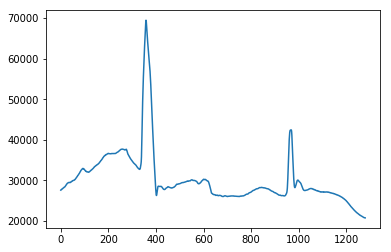

In [29]:
binary_warped = ipm[:,:,0] # R,G,B - select only B channel

histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)

midpoint = np.int(histogram.shape[0]/2)
left = np.argmax(histogram[:midpoint])
right = np.argmax(histogram[midpoint:]) + midpoint

print("Midpoint: ", midpoint)
print("Left: ", left, " right: ", right)

# 4.Image segmentation Functions

1. Generate Sobel derivative images with different gradient intensity thresholds.
2. Sobel derivative images with gradient magnitude thresholds.
3. Sobel derivative images with gradient angle/direction thresholds.

In [30]:
# THRESH functions:

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        #abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
        abs_sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        #abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        abs_sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def abs_sobel_thresh2(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 4) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 5) Return this mask as your binary_output image
    return sxbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Binary red channel threshold
def red_thres(img, thresh_min = 25, thresh_max = 255):
    red = img[:,:,2]
    red_binary = np.zeros_like(red)
    red_binary[(red >= thresh_min) & (red <= thresh_max)]  = 1
    return red_binary

def eq_Hist(img): # Histogram normalization
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    return img


# Binary saturation channel threshold
def s_thres(img, thresh_min = 25, thresh_max = 255):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > thresh_min) & (s_channel <= thresh_max)] = 1
    return s_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def s_hls(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    return hls[:,:,2]

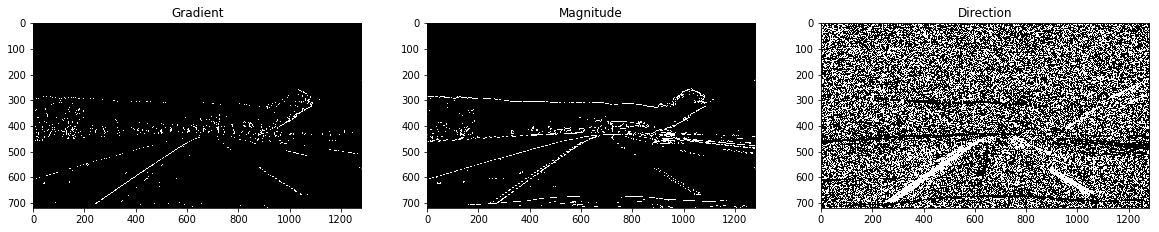

In [31]:
# Display the thresholding results
image = img2

# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh_min=20, thresh_max=100)
    
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))

# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))


plt.figure(figsize=(20,15))

plt.subplot(3,3,1)
plt.title('Gradient')
fig = plt.imshow(grad_binary, cmap="gray")

plt.subplot(3,3,2)
plt.title('Magnitude')
fig = plt.imshow(mag_binary, cmap="gray")

plt.subplot(3,3,3)
plt.title('Direction')
fig = plt.imshow(dir_binary, cmap="gray")


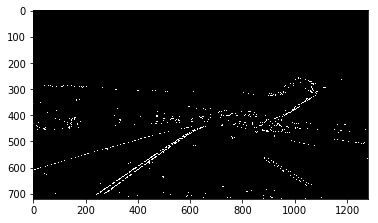

In [32]:
# Combine thresholding results.

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

image = img2

# Apply each of the thresholding functions 
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel = ksize, thresh_min = 20, thresh_max = 100)
grady = abs_sobel_thresh(image, orient='y', sobel_kernel = ksize, thresh_min = 20, thresh_max = 100)
mag_binary = mag_thresh(image, sobel_kernel = ksize, mag_thresh = (30, 100))
dir_binary = dir_threshold(image, sobel_kernel = ksize*3, thresh = (0.7, 1.3))  # 0, np.pi/2

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.imshow(combined, cmap="gray")

# 5.Convert to HLS and combine with Sobel on Grayscale

In [36]:
def binarize(img):
    img = eq_Hist(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
 
    #img_proc = img[:,:,2]+0.5*s_hls(img)
   # img_proc = np.uint8(255*img_proc/np.max(img_proc))
   # plt.imshow(img_proc, cmap='gray')
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

# Retuns binary image based on thresholding functions
def get_binary_image(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    light_mask = np.zeros_like(L)
    light_mask[(S >= 5) & (L >= 130)] = 1

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx_l = abs_sobel_thresh2(L, orient='x', sobel_kernel=ksize, thresh=(25, 100))
    gradx_s = abs_sobel_thresh2(S, orient='x', sobel_kernel=ksize, thresh=(10, 100))
    
    combined = np.zeros_like(gradx_s)
    # For some images S channel works better, while for others L channel does
    # Mix results from either channels
    combined[((gradx_l == 1) | (gradx_s == 1)) & (light_mask == 1)] = 1
    
    return combined


In [37]:
# Show combined thresh result
img = cv2.imread("test_images/test3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)





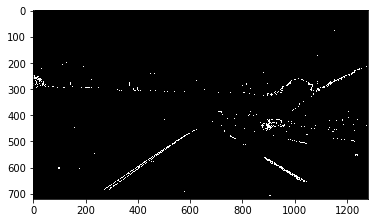

In [38]:
combined_binary = get_binary_image(img)#binarize(img)

plt.imshow(combined_binary, cmap='gray')

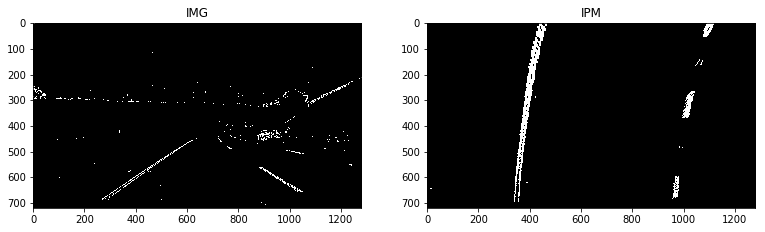

In [39]:

segmented_inverse_perpective = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR) 

plt.figure(figsize=(20,15))

plt.subplot(3,3,1)
plt.title('IMG')
fig = plt.imshow(combined_binary, cmap='gray')

plt.subplot(3,3,2)
plt.title('IPM')
fig = plt.imshow(segmented_inverse_perpective, cmap='gray')
plt.imsave("C:\\combinedBin.bmp",combined_binary)

# 6.Fit First Time Lines

In [95]:

def fit_lines(binary_warped): 
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(int(histogram.shape[0]/2))
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
        
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    
    return left_fit, right_fit,leftx,lefty,rightx,righty, out_img


(720, 0)

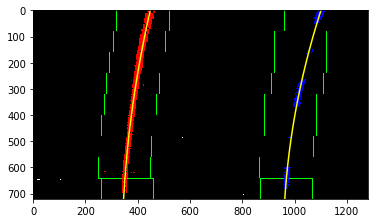

In [96]:
# Test and display the sliding window and fit curve algorithm
binary_warped = segmented_inverse_perpective
left_fit, right_fit,leftx,lefty,rightx,righty, out_img = fit_lines(binary_warped)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
plt.imsave("C:\\poli.bmp",out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


# 7. Fit Lines Continuous after first frame

In [97]:
def fit_lines_cont(left_fit, right_fit, binary_warped):
 
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
        
    return left_fit, right_fit, leftx,lefty, rightx, righty

(720, 0)

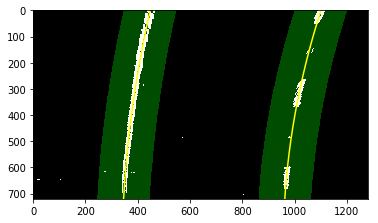

In [98]:
# Test and display fit continous function
binary_warped = segmented_inverse_perpective
left_fit, right_fit,leftx,lefty, rightx, righty = fit_lines_cont(left_fit, right_fit, binary_warped)

margin = 100
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# 8. Draw Line and Radius of curvature

In [99]:
def draw_line(undist, warped, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result 

In [105]:
def get_curvature2(left_fit, right_fit, segmented_inverse_perpective): 
    
    ploty = np.linspace(0, segmented_inverse_perpective.shape[0] - 1, segmented_inverse_perpective.shape[0])
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
   
    left_curverad = ((1 + (2*left_fit[0] * y_eval + left_fit[1])**2)**1.5)/np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0] * y_eval + right_fit[1])**2)**1.5)/np.absolute(2*right_fit[0])
    
    # Center is difference btw image center (@640 px, width is 1280px) and lane center (lane center is given by left x, right x coords / 2)
    center = (((left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]) + (right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2])) / 2 - 640) * xm_per_pix
   # print("center: ", center)
    return left_curverad, right_curverad, center

test_ipm = segmented_inverse_perpective
get_curvature(left_fit, right_fit, test_ipm)

(4183.7849500917937, 2809.9800435353004, 0.075391734673385655)

In [133]:
# Performs polynomial fit for the given points. Returns polynomial fit and residual.
def fit_line(line_x, line_y, order_polynomial = 2):
    fit, residual, _, _, _ = np.polyfit(line_y, line_x, order_polynomial, full = True)
    return fit, residual

# Evaluates polynomial and finds value at given point
def get_x_for_line(line_fit, line_y):
    poly = np.poly1d(line_fit)
    return poly(line_y)

# Calculates curvature given lane polynomial fit and bottom vertical point
def get_curvature(line_fit, y_eval):
    return ((1 + (2 * line_fit[0] * y_eval + line_fit[1]) ** 2) ** 1.5) \
                             / np.absolute(2 * line_fit[0])

# Calculates curvature and distance from center, in meters
def get_curvature_and_distance_from_center(left_lane_coordinates, right_lane_coordinates, image_width, image_height):
    # Define conversions in x and y from pixels space to meters
    lane_width_pix = image_width * 0.57
    ym_per_pix = 30 / image_height # meters per pixel in y dimension
    xm_per_pix = 3.7 / lane_width_pix # meteres per pixel in x dimension
    
    # Find lanes fit in in meters
    left_fit_cr, _ = fit_line(left_lane_coordinates[1] * xm_per_pix, left_lane_coordinates[0] * ym_per_pix)
    right_fit_cr, _ = fit_line(right_lane_coordinates[1] * xm_per_pix, right_lane_coordinates[0] * ym_per_pix)
    
    # Calculate X coordinates for each fit
    y_vals_cr = np.arange(0, image_height * ym_per_pix)
    left_fit_cr_x = get_x_for_line(left_fit_cr, y_vals_cr)
    right_fit_cr_x = get_x_for_line(right_fit_cr, y_vals_cr)
    
     
    # Calculate curvature of the lane at the bottom of the image, in meters
    left_curverad = get_curvature(left_fit_cr, image_height * ym_per_pix)
    right_curverad = get_curvature(right_fit_cr, image_height * ym_per_pix)
    print(left_curverad, 'm', right_curverad, 'm')
    center = (((left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]) + (right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2])) / 2 - 640) * xm_per_pix
 
    
    return left_curverad, right_curverad, center


In [134]:
imgh = img2.shape[0]
imgw = img2.shape[1]
print(imgw)
print(imgh)
left_lane_coordinates = []
right_lane_coordinates = []
left_lane_coordinates.append(leftx)
left_lane_coordinates.append(lefty)
right_lane_coordinates.append(rightx)
right_lane_coordinates.append(righty)


left_cur, right_cur,dfc = get_curvature_and_distance_from_center(left_lane_coordinates, right_lane_coordinates, imgw, imgh)

print("Right Curvature ", right_cur)
print("Left curvature ", left_cur)
print("Center", dfc)


1280
720
15.2926939256 m 107.485355411 m
Right Curvature  107.485355411
Left curvature  15.2926939256
Center -1.24030828844


# 9.Process lane

The process lane method encapsulates all the necesary steps to find lanes. 


In [135]:

def process_lane(image):
    img_undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    global counter
    global ref_left 
    global ref_right
    global left_fit
    global right_fit
    
    img = get_binary_image(img_undist)#binarize(img_undist)
    img_size = (img.shape[1], img.shape[0])
    ipm = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    #img_unpersp = cv2.warpPerspective(ipm, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    if counter == 0:
        left_fit, right_fit, leftx, lefty, rightx, righty, out_img = fit_lines(ipm)
    else:
        left_fit, right_fit, leftx, lefty, rightx, righty = fit_lines_cont(left_fit, right_fit, ipm)
    
    ok = True 
    
    if ok == True:         
        ref_left, ref_right = left_fit, right_fit        
        counter += 1
    else:         
        left_fit, right_fit = ref_left, ref_right
        
    
    img_dl = draw_line(img_undist, ipm, left_fit, right_fit)
    #plt.imshow(img_dl)
    
    final_result = np.zeros((576,1280,3), dtype=np.uint8)

    final_result[0:576, 0:1024, 0:3] = cv2.resize(img_dl, (1024,576)) 
    final_result[0:288, 1024:1280, 0] = cv2.resize(ipm * 255, (256,288)) 
    final_result[0:288, 1024:1280, 1] = cv2.resize(ipm * 255, (256,288)) 
    final_result[0:288, 1024:1280, 2] = cv2.resize(ipm * 255, (256,288)) 
    final_result[288:576, 1024:1280, 0:3] = cv2.resize(image, (256,288))
    
    imgh = image.shape[0]
    imgw = image.shape[1]

    left_lane_coordinates = []
    right_lane_coordinates = []
    left_lane_coordinates.append(leftx)
    left_lane_coordinates.append(lefty)
    right_lane_coordinates.append(rightx)
    right_lane_coordinates.append(righty)

    left_curv, right_curv,center = get_curvature_and_distance_from_center(left_lane_coordinates, right_lane_coordinates, imgw, imgh)
    
   # left_curv, right_curv, center = get_curvature(left_fit, right_fit, ipm)
    txt_left = "L curvature: " + str(round(left_curv, 1)) + "m"
    txt_right = "R curvature: " + str(round(right_curv, 1)) + "m"
    
    cv2.putText(final_result, txt_left, (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2,  lineType = cv2.LINE_AA)
    cv2.putText(final_result, txt_right, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2,  lineType = cv2.LINE_AA)
    
    center_txt = "Offset: " + str(round(center, 2)) + "m"
    cv2.putText(final_result, center_txt, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2,  lineType = cv2.LINE_AA)
    
    
    return final_result

18.7046454611 m 107.029299101 m
6853.29930425 m 175.083970253 m
420.078865595 m 696.785146748 m
298.575727196 m 16.3261003197 m
105.491498919 m 72.6524549828 m
42.2598060065 m 259.952317431 m
381.640946346 m 19.0467183141 m
171.010888555 m 105.161519935 m
30.5783187917 m 107.029299101 m


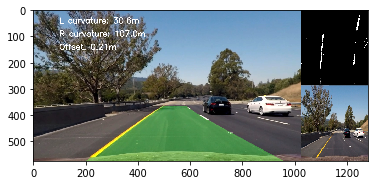

In [141]:
# Test process lane and display result
counter = 0
#r = process_lane(img2)
#plt.imshow(r)
#plt.imsave("C:\\img.bmp",r)
img = cv2.imread("test_images/test6.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
r = process_lane(imgRGB)
plt.imshow(r)
plt.imsave("C:\\img8.bmp",r)

images = glob.glob("C:/Users/Dan/Desktop/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/test_images/*.jpg")

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    r = process_lane(imgRGB)
    plt.imshow(r)
    saveStr = "C:/Users/Dan/Desktop/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/output_images/" + str(idx) + ".bmp"
    plt.imsave(saveStr,r)
  
 

# Generate processed video


In [125]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [126]:
white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_lane) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

183.429692896 m 1387.98646245 m
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


  0%|                                                 | 0/1261 [00:00<?, ?it/s]

113.752220571 m 19.8917638292 m


  0%|                                         | 1/1261 [00:00<03:20,  6.28it/s]

113.060615828 m 15.5544172974 m


  0%|                                         | 2/1261 [00:00<03:18,  6.34it/s]

112.518685461 m 14.4400067378 m


  0%|                                         | 3/1261 [00:00<03:18,  6.34it/s]

110.247725023 m 12.4629104073 m


  0%|▏                                        | 4/1261 [00:00<03:21,  6.24it/s]

107.042855814 m 12.9518370103 m


  0%|▏                                        | 5/1261 [00:00<03:30,  5.96it/s]

106.268618433 m 12.1008376199 m


  0%|▏                                        | 6/1261 [00:01<03:35,  5.83it/s]

98.987975548 m 12.6005265571 m


  1%|▏                                        | 7/1261 [00:01<03:37,  5.78it/s]

94.2320462146 m 16.3063010342 m


  1%|▎                                        | 8/1261 [00:01<03:37,  5.76it/s]

89.3206836298 m 12.1321728487 m


  1%|▎                                        | 9/1261 [00:01<03:37,  5.76it/s]

87.6798469508 m 12.0881935778 m


  1%|▎                                       | 10/1261 [00:01<03:33,  5.87it/s]

87.5158958459 m 12.3706571493 m


  1%|▎                                       | 11/1261 [00:01<03:35,  5.80it/s]

84.6262173353 m 19.452104874 m


  1%|▍                                       | 12/1261 [00:02<03:40,  5.67it/s]

85.0513975772 m 12.0451057596 m


  1%|▍                                       | 13/1261 [00:02<03:44,  5.57it/s]

85.2033587388 m 13.1521511252 m


  1%|▍                                       | 14/1261 [00:02<03:41,  5.63it/s]

85.5982352658 m 13.3102897204 m


  1%|▍                                       | 15/1261 [00:02<03:34,  5.81it/s]

85.9053444362 m 14.0629740579 m


  1%|▌                                       | 16/1261 [00:02<03:26,  6.03it/s]

86.3713790209 m 13.4802475054 m


  1%|▌                                       | 17/1261 [00:02<03:21,  6.19it/s]

86.4692396242 m 15.5967581305 m


  1%|▌                                       | 18/1261 [00:03<03:16,  6.33it/s]

86.9089119037 m 12.6168269346 m


  2%|▌                                       | 19/1261 [00:03<03:11,  6.49it/s]

87.9849573191 m 12.3985879542 m


  2%|▋                                       | 20/1261 [00:03<03:10,  6.53it/s]

89.3250475176 m 14.9890950015 m


  2%|▋                                       | 21/1261 [00:03<03:06,  6.66it/s]

90.0934547887 m 11.1399619299 m


  2%|▋                                       | 22/1261 [00:03<03:07,  6.62it/s]

89.248142579 m 15.0284016017 m


  2%|▋                                       | 23/1261 [00:03<03:07,  6.61it/s]

89.6290585536 m 14.8473499493 m


  2%|▊                                       | 24/1261 [00:03<03:06,  6.64it/s]

90.2712976795 m 11.3604314719 m


  2%|▊                                       | 25/1261 [00:04<03:06,  6.62it/s]

90.8942515294 m 10.8048614871 m


  2%|▊                                       | 26/1261 [00:04<03:06,  6.63it/s]

92.3221083383 m 12.3223210852 m


  2%|▊                                       | 27/1261 [00:04<03:06,  6.60it/s]

93.5081565844 m 20.2307226133 m


  2%|▉                                       | 28/1261 [00:04<03:06,  6.62it/s]

97.7546724932 m 20.8007621979 m


  2%|▉                                       | 29/1261 [00:04<03:06,  6.61it/s]

105.377974641 m 13.0046810305 m


  2%|▉                                       | 30/1261 [00:04<03:05,  6.65it/s]

104.594672682 m 11.8929329847 m


  2%|▉                                       | 31/1261 [00:04<03:05,  6.64it/s]

110.576724943 m 11.2650536411 m


  3%|█                                       | 32/1261 [00:05<03:03,  6.70it/s]

115.436778545 m 11.7432485546 m


  3%|█                                       | 33/1261 [00:05<03:02,  6.72it/s]

110.573195737 m 12.272549629 m


  3%|█                                       | 34/1261 [00:05<02:56,  6.94it/s]

113.664110047 m 12.4590236145 m


  3%|█                                       | 35/1261 [00:05<02:53,  7.05it/s]

111.634819286 m 13.5963862184 m


  3%|█▏                                      | 36/1261 [00:05<02:52,  7.11it/s]

105.704979871 m 14.8440642914 m


  3%|█▏                                      | 37/1261 [00:05<02:51,  7.15it/s]

109.001201883 m 15.0697691873 m


  3%|█▏                                      | 38/1261 [00:05<02:49,  7.21it/s]

107.070676347 m 14.3353179633 m


  3%|█▏                                      | 39/1261 [00:06<02:46,  7.33it/s]

102.051895277 m 13.299142024 m


  3%|█▎                                      | 40/1261 [00:06<02:47,  7.27it/s]

101.621802695 m 12.7377474983 m


  3%|█▎                                      | 41/1261 [00:06<02:50,  7.15it/s]

99.1363210861 m 12.1213412964 m


  3%|█▎                                      | 42/1261 [00:06<02:49,  7.21it/s]

94.6538103186 m 11.4944755011 m


  3%|█▎                                      | 43/1261 [00:06<02:55,  6.93it/s]

91.6397618968 m 11.1990548159 m


  3%|█▍                                      | 44/1261 [00:06<02:52,  7.04it/s]

88.226367641 m 11.4692722918 m


  4%|█▍                                      | 45/1261 [00:06<02:54,  6.98it/s]

87.5869260683 m 23.5869904723 m


  4%|█▍                                      | 46/1261 [00:07<02:51,  7.07it/s]

84.7234528912 m 13.6708370286 m


  4%|█▍                                      | 47/1261 [00:07<02:49,  7.17it/s]

83.9280856878 m 13.562725639 m


  4%|█▌                                      | 48/1261 [00:07<02:49,  7.14it/s]

83.288809247 m 12.2987691064 m


  4%|█▌                                      | 49/1261 [00:07<02:54,  6.95it/s]

82.818476495 m 14.3676071162 m


  4%|█▌                                      | 50/1261 [00:07<02:54,  6.93it/s]

83.2409984241 m 13.949941378 m


  4%|█▌                                      | 51/1261 [00:07<02:52,  7.02it/s]

84.139864091 m 12.7863353344 m


  4%|█▋                                      | 52/1261 [00:07<02:51,  7.06it/s]

84.5939664124 m 12.7742776649 m


  4%|█▋                                      | 53/1261 [00:08<02:49,  7.11it/s]

85.2734399023 m 13.013468361 m


  4%|█▋                                      | 54/1261 [00:08<02:49,  7.12it/s]

85.9149912958 m 11.8706690692 m


  4%|█▋                                      | 55/1261 [00:08<02:48,  7.15it/s]

87.5904442299 m 11.5770063012 m


  4%|█▊                                      | 56/1261 [00:08<02:49,  7.09it/s]

88.29847803 m 12.1693716274 m


  5%|█▊                                      | 57/1261 [00:08<02:49,  7.12it/s]

89.0766160206 m 14.5411749171 m


  5%|█▊                                      | 58/1261 [00:08<02:48,  7.16it/s]

87.4979379624 m 22.8409413213 m


  5%|█▊                                      | 59/1261 [00:08<02:49,  7.10it/s]

88.750335366 m 26.5450976343 m


  5%|█▉                                      | 60/1261 [00:09<02:50,  7.04it/s]

90.4301762519 m 32.372252428 m


  5%|█▉                                      | 61/1261 [00:09<02:54,  6.86it/s]

93.9652981911 m 25.8304739104 m


  5%|█▉                                      | 62/1261 [00:09<02:53,  6.93it/s]

95.5593328967 m 27.9583564135 m


  5%|█▉                                      | 63/1261 [00:09<02:49,  7.08it/s]

98.6549701112 m 20.7082012124 m


  5%|██                                      | 64/1261 [00:09<02:52,  6.93it/s]

101.365568286 m 18.0860791139 m


  5%|██                                      | 65/1261 [00:09<02:52,  6.95it/s]

105.472553109 m 17.1369159617 m


  5%|██                                      | 66/1261 [00:09<02:52,  6.95it/s]

106.059636875 m 14.8774669578 m


  5%|██▏                                     | 67/1261 [00:10<02:52,  6.93it/s]

107.438486667 m 12.6870795244 m


  5%|██▏                                     | 68/1261 [00:10<02:54,  6.85it/s]

106.91733538 m 14.2869977657 m


  5%|██▏                                     | 69/1261 [00:10<02:50,  7.01it/s]

99.2695708949 m 11.6567122152 m


  6%|██▏                                     | 70/1261 [00:10<02:46,  7.17it/s]

96.9275437522 m 13.5315665193 m


  6%|██▎                                     | 71/1261 [00:10<02:43,  7.30it/s]

96.2760221394 m 10.9744411247 m


  6%|██▎                                     | 72/1261 [00:10<02:45,  7.20it/s]

94.1067635963 m 13.4671653462 m


  6%|██▎                                     | 73/1261 [00:10<02:47,  7.09it/s]

94.6848884032 m 11.5781849897 m


  6%|██▎                                     | 74/1261 [00:11<02:49,  7.02it/s]

96.2035112948 m 10.8402618858 m


  6%|██▍                                     | 75/1261 [00:11<02:48,  7.04it/s]

95.5168267027 m 10.5314067585 m


  6%|██▍                                     | 76/1261 [00:11<02:47,  7.08it/s]

97.2621092965 m 10.5461139686 m


  6%|██▍                                     | 77/1261 [00:11<02:46,  7.10it/s]

102.074680329 m 11.4239595596 m


  6%|██▍                                     | 78/1261 [00:11<02:44,  7.19it/s]

106.316504252 m 11.299775431 m


  6%|██▌                                     | 79/1261 [00:11<02:45,  7.13it/s]

101.844023583 m 11.6905344695 m


  6%|██▌                                     | 80/1261 [00:11<02:47,  7.04it/s]

100.74483481 m 10.9221319406 m


  6%|██▌                                     | 81/1261 [00:12<02:47,  7.05it/s]

101.970956334 m 11.3604710661 m


  7%|██▌                                     | 82/1261 [00:12<02:46,  7.08it/s]

103.579533647 m 10.1795831728 m


  7%|██▋                                     | 83/1261 [00:12<02:46,  7.07it/s]

103.0029779 m 10.5130507182 m


  7%|██▋                                     | 84/1261 [00:12<02:51,  6.85it/s]

105.700053151 m 11.5627961693 m


  7%|██▋                                     | 85/1261 [00:12<02:51,  6.84it/s]

114.46206937 m 16.9353661132 m


  7%|██▋                                     | 86/1261 [00:12<02:50,  6.91it/s]

126.221715212 m 10.3463355904 m


  7%|██▊                                     | 87/1261 [00:12<02:52,  6.79it/s]

143.744335526 m 14.7161811025 m


  7%|██▊                                     | 88/1261 [00:13<02:51,  6.82it/s]

161.491587334 m 12.5416196502 m


  7%|██▊                                     | 89/1261 [00:13<02:53,  6.76it/s]

187.05972158 m 12.5652305719 m


  7%|██▊                                     | 90/1261 [00:13<02:48,  6.95it/s]

168.383071664 m 10.9077702609 m


  7%|██▉                                     | 91/1261 [00:13<02:48,  6.95it/s]

170.623025254 m 9.92926678001 m


  7%|██▉                                     | 92/1261 [00:13<02:48,  6.92it/s]

185.024082342 m 9.73605677793 m


  7%|██▉                                     | 93/1261 [00:13<02:50,  6.85it/s]

174.295577083 m 9.69296397793 m


  7%|██▉                                     | 94/1261 [00:13<02:48,  6.94it/s]

158.97659863 m 9.59012934516 m


  8%|███                                     | 95/1261 [00:14<02:46,  7.00it/s]

149.690460408 m 10.5105442418 m


  8%|███                                     | 96/1261 [00:14<02:46,  7.01it/s]

142.234045755 m 9.99942569619 m


  8%|███                                     | 97/1261 [00:14<02:46,  6.97it/s]

137.770499154 m 11.851253984 m


  8%|███                                     | 98/1261 [00:14<02:44,  7.05it/s]

132.665908554 m 10.1667437046 m


  8%|███▏                                    | 99/1261 [00:14<02:44,  7.06it/s]

127.584929687 m 9.65093153988 m


  8%|███                                    | 100/1261 [00:14<02:46,  6.97it/s]

128.690855361 m 9.74877684507 m


  8%|███                                    | 101/1261 [00:14<02:44,  7.03it/s]

135.097326638 m 9.7766397987 m


  8%|███▏                                   | 102/1261 [00:15<02:48,  6.89it/s]

131.96154241 m 9.57875274247 m


  8%|███▏                                   | 103/1261 [00:15<02:47,  6.90it/s]

136.338805453 m 9.66369377701 m


  8%|███▏                                   | 104/1261 [00:15<02:47,  6.90it/s]

125.799745963 m 12.7036991256 m


  8%|███▏                                   | 105/1261 [00:15<02:48,  6.87it/s]

125.387577726 m 14.790668425 m


  8%|███▎                                   | 106/1261 [00:15<02:49,  6.81it/s]

124.293928119 m 18.1540103782 m


  8%|███▎                                   | 107/1261 [00:15<02:48,  6.86it/s]

128.96309278 m 11.1381317019 m


  9%|███▎                                   | 108/1261 [00:15<02:49,  6.79it/s]

131.736755192 m 11.8422723029 m


  9%|███▎                                   | 109/1261 [00:16<02:49,  6.79it/s]

128.131253031 m 12.2521957063 m


  9%|███▍                                   | 110/1261 [00:16<02:49,  6.79it/s]

130.196815498 m 16.5010967359 m


  9%|███▍                                   | 111/1261 [00:16<02:47,  6.85it/s]

119.836811701 m 29.5649877293 m


  9%|███▍                                   | 112/1261 [00:16<02:47,  6.88it/s]

123.656531514 m 14.418510501 m


  9%|███▍                                   | 113/1261 [00:16<02:47,  6.87it/s]

126.226522419 m 17.5287730829 m


  9%|███▌                                   | 114/1261 [00:16<02:45,  6.92it/s]

129.533942495 m 11.7571358675 m


  9%|███▌                                   | 115/1261 [00:16<02:45,  6.91it/s]

131.560850238 m 10.9413012292 m


  9%|███▌                                   | 116/1261 [00:17<02:46,  6.88it/s]

129.8020905 m 11.7417879062 m


  9%|███▌                                   | 117/1261 [00:17<02:47,  6.81it/s]

129.609084461 m 12.2138013745 m


  9%|███▋                                   | 118/1261 [00:17<02:46,  6.88it/s]

127.913352843 m 12.4588618462 m


  9%|███▋                                   | 119/1261 [00:17<02:45,  6.91it/s]

124.901304718 m 11.4714511496 m


 10%|███▋                                   | 120/1261 [00:17<02:45,  6.88it/s]

118.135203766 m 11.9942695054 m


 10%|███▋                                   | 121/1261 [00:17<02:43,  6.98it/s]

115.943140289 m 12.0824044131 m


 10%|███▊                                   | 122/1261 [00:17<02:42,  7.00it/s]

116.457370315 m 15.9142169536 m


 10%|███▊                                   | 123/1261 [00:18<02:41,  7.04it/s]

114.80144652 m 15.7665839506 m


 10%|███▊                                   | 124/1261 [00:18<02:43,  6.94it/s]

111.614567125 m 16.6652874274 m


 10%|███▊                                   | 125/1261 [00:18<02:45,  6.85it/s]

106.303113179 m 12.0691903899 m


 10%|███▉                                   | 126/1261 [00:18<02:44,  6.91it/s]

106.516999198 m 12.9177320603 m


 10%|███▉                                   | 127/1261 [00:18<02:44,  6.90it/s]

104.73553293 m 11.8251335594 m


 10%|███▉                                   | 128/1261 [00:18<02:43,  6.93it/s]

103.549808268 m 12.4580510692 m


 10%|███▉                                   | 129/1261 [00:18<02:44,  6.89it/s]

101.320974118 m 11.2739062819 m


 10%|████                                   | 130/1261 [00:19<02:44,  6.89it/s]

100.142694122 m 11.1450596674 m


 10%|████                                   | 131/1261 [00:19<02:44,  6.86it/s]

99.5586405206 m 11.2983139222 m


 10%|████                                   | 132/1261 [00:19<02:46,  6.79it/s]

95.5014783918 m 11.3640356366 m


 11%|████                                   | 133/1261 [00:19<02:44,  6.86it/s]

92.866034183 m 14.2860062629 m


 11%|████▏                                  | 134/1261 [00:19<02:41,  6.98it/s]

93.8667296139 m 14.9210534323 m


 11%|████▏                                  | 135/1261 [00:19<02:44,  6.86it/s]

90.5708263801 m 12.8427344859 m


 11%|████▏                                  | 136/1261 [00:20<02:44,  6.85it/s]

91.4902177456 m 13.7755210811 m


 11%|████▏                                  | 137/1261 [00:20<02:42,  6.94it/s]

91.2025391567 m 13.3423114509 m


 11%|████▎                                  | 138/1261 [00:20<02:39,  7.02it/s]

91.8451490842 m 12.4793663822 m


 11%|████▎                                  | 139/1261 [00:20<02:40,  6.98it/s]

91.6902363524 m 11.4756575547 m


 11%|████▎                                  | 140/1261 [00:20<02:43,  6.87it/s]

93.9972427936 m 11.6861787313 m


 11%|████▎                                  | 141/1261 [00:20<02:40,  6.96it/s]

94.1512355156 m 11.1847137549 m


 11%|████▍                                  | 142/1261 [00:20<02:40,  6.97it/s]

97.4262727834 m 11.0867013027 m


 11%|████▍                                  | 143/1261 [00:21<02:39,  7.02it/s]

98.3903003226 m 10.8733454809 m


 11%|████▍                                  | 144/1261 [00:21<02:39,  7.01it/s]

95.6928254415 m 11.1417235812 m


 11%|████▍                                  | 145/1261 [00:21<02:43,  6.85it/s]

97.953728532 m 11.611984575 m


 12%|████▌                                  | 146/1261 [00:21<02:42,  6.87it/s]

95.5526714707 m 13.3673172132 m


 12%|████▌                                  | 147/1261 [00:21<02:41,  6.91it/s]

102.655377809 m 16.8243968692 m


 12%|████▌                                  | 148/1261 [00:21<02:43,  6.79it/s]

105.00552577 m 15.9064937747 m


 12%|████▌                                  | 149/1261 [00:21<02:42,  6.85it/s]

102.604769189 m 13.1528013757 m


 12%|████▋                                  | 150/1261 [00:22<02:44,  6.76it/s]

103.756976074 m 11.2304653989 m


 12%|████▋                                  | 151/1261 [00:22<02:42,  6.82it/s]

102.158179422 m 11.0997981577 m


 12%|████▋                                  | 152/1261 [00:22<02:46,  6.65it/s]

107.74267228 m 10.9705792328 m


 12%|████▋                                  | 153/1261 [00:22<02:46,  6.66it/s]

103.999434021 m 10.7527800488 m


 12%|████▊                                  | 154/1261 [00:22<02:46,  6.65it/s]

104.590393722 m 11.3597991975 m


 12%|████▊                                  | 155/1261 [00:22<02:44,  6.73it/s]

103.882494598 m 11.8832599086 m


 12%|████▊                                  | 156/1261 [00:22<02:40,  6.89it/s]

104.357520159 m 11.4468520512 m


 12%|████▊                                  | 157/1261 [00:23<02:36,  7.05it/s]

108.305950113 m 11.315938086 m


 13%|████▉                                  | 158/1261 [00:23<02:35,  7.09it/s]

107.873842497 m 42.7952322536 m


 13%|████▉                                  | 159/1261 [00:23<02:38,  6.96it/s]

108.76306457 m 42.1480695731 m


 13%|████▉                                  | 160/1261 [00:23<02:40,  6.84it/s]

103.448148626 m 13.9276193309 m


 13%|████▉                                  | 161/1261 [00:23<02:40,  6.85it/s]

102.857537873 m 17.9342446576 m


 13%|█████                                  | 162/1261 [00:23<02:42,  6.77it/s]

99.0741636066 m 24.7660844645 m


 13%|█████                                  | 163/1261 [00:23<02:42,  6.76it/s]

101.299217552 m 14.7686772499 m


 13%|█████                                  | 164/1261 [00:24<02:38,  6.93it/s]

100.139617513 m 15.0099915972 m


 13%|█████                                  | 165/1261 [00:24<02:41,  6.78it/s]

100.782734369 m 12.7580819629 m


 13%|█████▏                                 | 166/1261 [00:24<02:38,  6.90it/s]

102.846944904 m 13.7239899225 m


 13%|█████▏                                 | 167/1261 [00:24<02:38,  6.91it/s]

95.9816531894 m 11.0944768911 m


 13%|█████▏                                 | 168/1261 [00:24<02:39,  6.86it/s]

94.2777409024 m 10.523312737 m


 13%|█████▏                                 | 169/1261 [00:24<02:38,  6.90it/s]

90.9121325666 m 10.5486037463 m


 13%|█████▎                                 | 170/1261 [00:24<02:38,  6.90it/s]

90.8437849572 m 14.5566176677 m


 14%|█████▎                                 | 171/1261 [00:25<02:37,  6.91it/s]

91.3350488205 m 15.6494094321 m


 14%|█████▎                                 | 172/1261 [00:25<02:35,  7.02it/s]

92.0048054306 m 11.6177136721 m


 14%|█████▎                                 | 173/1261 [00:25<02:35,  7.01it/s]

94.3407377784 m 14.4777205991 m


 14%|█████▍                                 | 174/1261 [00:25<02:33,  7.06it/s]

96.5929702634 m 11.6514997886 m


 14%|█████▍                                 | 175/1261 [00:25<02:36,  6.92it/s]

98.0810100401 m 12.8874605087 m


 14%|█████▍                                 | 176/1261 [00:25<02:37,  6.89it/s]

96.7576500154 m 11.0829428926 m


 14%|█████▍                                 | 177/1261 [00:25<02:38,  6.86it/s]

99.1025325881 m 10.6467167802 m


 14%|█████▌                                 | 178/1261 [00:26<02:36,  6.94it/s]

102.184950388 m 10.5666623096 m


 14%|█████▌                                 | 179/1261 [00:26<02:34,  6.98it/s]

106.547802196 m 11.1192138211 m


 14%|█████▌                                 | 180/1261 [00:26<02:34,  7.00it/s]

113.223608272 m 11.0538564488 m


 14%|█████▌                                 | 181/1261 [00:26<02:32,  7.09it/s]

115.658328439 m 11.4430945727 m


 14%|█████▋                                 | 182/1261 [00:26<02:30,  7.16it/s]

128.244326688 m 13.0010959243 m


 15%|█████▋                                 | 183/1261 [00:26<02:31,  7.11it/s]

136.179216399 m 18.3702103679 m


 15%|█████▋                                 | 184/1261 [00:26<02:29,  7.21it/s]

137.981084152 m 25.3228808653 m


 15%|█████▋                                 | 185/1261 [00:27<02:28,  7.24it/s]

140.493624103 m 24.7515010856 m


 15%|█████▊                                 | 186/1261 [00:27<02:31,  7.10it/s]

127.068890504 m 29.5348986516 m


 15%|█████▊                                 | 187/1261 [00:27<02:29,  7.19it/s]

125.622523095 m 32.2970272839 m


 15%|█████▊                                 | 188/1261 [00:27<02:27,  7.25it/s]

121.484280687 m 29.5372583686 m


 15%|█████▊                                 | 189/1261 [00:27<02:28,  7.22it/s]

119.934429605 m 24.3192287243 m


 15%|█████▉                                 | 190/1261 [00:27<02:30,  7.13it/s]

117.631468879 m 24.4265291542 m


 15%|█████▉                                 | 191/1261 [00:27<02:30,  7.13it/s]

114.972517202 m 18.7820550477 m


 15%|█████▉                                 | 192/1261 [00:28<02:33,  6.98it/s]

110.970829622 m 19.7117481767 m


 15%|█████▉                                 | 193/1261 [00:28<02:34,  6.91it/s]

105.898670663 m 17.0780338964 m


 15%|██████                                 | 194/1261 [00:28<02:35,  6.88it/s]

104.346628082 m 24.1088212635 m


 15%|██████                                 | 195/1261 [00:28<02:37,  6.77it/s]

96.0947698231 m 27.5410963097 m


 16%|██████                                 | 196/1261 [00:28<02:37,  6.78it/s]

93.4848750309 m 12.2745451913 m


 16%|██████                                 | 197/1261 [00:28<02:36,  6.78it/s]

89.9512349319 m 11.4182048675 m


 16%|██████                                 | 198/1261 [00:28<02:36,  6.80it/s]

88.8060408814 m 14.2453927599 m


 16%|██████▏                                | 199/1261 [00:29<02:33,  6.91it/s]

88.9775908004 m 17.8114806775 m


 16%|██████▏                                | 200/1261 [00:29<02:33,  6.92it/s]

89.4531563993 m 17.862975625 m


 16%|██████▏                                | 201/1261 [00:29<02:35,  6.80it/s]

90.7956349733 m 12.2723908976 m


 16%|██████▏                                | 202/1261 [00:29<02:36,  6.76it/s]

92.7174929417 m 11.7458104914 m


 16%|██████▎                                | 203/1261 [00:29<02:35,  6.80it/s]

93.3627937509 m 10.925130285 m


 16%|██████▎                                | 204/1261 [00:29<02:34,  6.85it/s]

96.9248703746 m 10.9652595562 m


 16%|██████▎                                | 205/1261 [00:29<02:34,  6.84it/s]

99.5172501767 m 10.9737966533 m


 16%|██████▎                                | 206/1261 [00:30<02:35,  6.78it/s]

104.426344122 m 12.2994983498 m


 16%|██████▍                                | 207/1261 [00:30<02:32,  6.93it/s]

107.448347583 m 19.2723838141 m


 16%|██████▍                                | 208/1261 [00:30<02:29,  7.03it/s]

104.420538851 m 15.2978135546 m


 17%|██████▍                                | 209/1261 [00:30<02:27,  7.11it/s]

102.095463651 m 16.0518726167 m


 17%|██████▍                                | 210/1261 [00:30<02:27,  7.15it/s]

97.3411412875 m 11.674045466 m


 17%|██████▌                                | 211/1261 [00:30<02:31,  6.92it/s]

98.4860758855 m 15.8675992948 m


 17%|██████▌                                | 212/1261 [00:30<02:32,  6.86it/s]

98.158018749 m 15.6468110353 m


 17%|██████▌                                | 213/1261 [00:31<02:29,  7.00it/s]

99.3442806921 m 12.0708020442 m


 17%|██████▌                                | 214/1261 [00:31<02:32,  6.88it/s]

98.3417628029 m 13.9851994323 m


 17%|██████▋                                | 215/1261 [00:31<02:29,  7.00it/s]

97.053451278 m 14.4374001684 m


 17%|██████▋                                | 216/1261 [00:31<02:27,  7.10it/s]

96.5172711122 m 14.101583999 m


 17%|██████▋                                | 217/1261 [00:31<02:31,  6.90it/s]

92.8331962519 m 12.1009720526 m


 17%|██████▋                                | 218/1261 [00:31<02:30,  6.92it/s]

92.8140927519 m 14.2218945625 m


 17%|██████▊                                | 219/1261 [00:31<02:29,  6.95it/s]

89.2688785143 m 14.4783961998 m


 17%|██████▊                                | 220/1261 [00:32<02:31,  6.86it/s]

89.3368934853 m 18.8046007439 m


 18%|██████▊                                | 221/1261 [00:32<02:30,  6.90it/s]

89.0155448295 m 15.6544827672 m


 18%|██████▊                                | 222/1261 [00:32<02:32,  6.81it/s]

89.1324022117 m 13.8881569204 m


 18%|██████▉                                | 223/1261 [00:32<02:31,  6.86it/s]

90.009069127 m 28.6052823854 m


 18%|██████▉                                | 224/1261 [00:32<02:33,  6.75it/s]

89.8674548447 m 20.9281534651 m


 18%|██████▉                                | 225/1261 [00:32<02:33,  6.75it/s]

90.2619262685 m 22.4664145623 m


 18%|██████▉                                | 226/1261 [00:33<02:32,  6.78it/s]

90.4191053615 m 15.6022925089 m


 18%|███████                                | 227/1261 [00:33<02:33,  6.73it/s]

90.7621662686 m 15.0175441579 m


 18%|███████                                | 228/1261 [00:33<02:33,  6.75it/s]

91.3450732841 m 12.5353605823 m


 18%|███████                                | 229/1261 [00:33<02:30,  6.85it/s]

91.2975445223 m 10.0298479235 m


 18%|███████                                | 230/1261 [00:33<02:27,  6.98it/s]

91.2684145441 m 9.85291948105 m


 18%|███████▏                               | 231/1261 [00:33<02:27,  6.99it/s]

91.8437865667 m 9.86977003494 m


 18%|███████▏                               | 232/1261 [00:33<02:29,  6.89it/s]

92.7171694216 m 11.7956196502 m


 18%|███████▏                               | 233/1261 [00:34<02:28,  6.92it/s]

93.6400166901 m 11.0113531006 m


 19%|███████▏                               | 234/1261 [00:34<02:26,  7.00it/s]

93.9163936075 m 11.7850108769 m


 19%|███████▎                               | 235/1261 [00:34<02:27,  6.94it/s]

94.4014928912 m 14.4130092881 m


 19%|███████▎                               | 236/1261 [00:34<02:29,  6.85it/s]

95.5872935005 m 13.8318940205 m


 19%|███████▎                               | 237/1261 [00:34<02:25,  7.02it/s]

97.230073127 m 14.5757550284 m


 19%|███████▎                               | 238/1261 [00:34<02:28,  6.91it/s]

101.17286558 m 14.825104411 m


 19%|███████▍                               | 239/1261 [00:34<02:28,  6.89it/s]

102.43112224 m 12.7282947471 m


 19%|███████▍                               | 240/1261 [00:35<02:29,  6.85it/s]

105.43674364 m 11.4528153856 m


 19%|███████▍                               | 241/1261 [00:35<02:25,  7.02it/s]

105.615719967 m 10.2126469725 m


 19%|███████▍                               | 242/1261 [00:35<02:24,  7.06it/s]

111.255201718 m 10.8919194825 m


 19%|███████▌                               | 243/1261 [00:35<02:25,  7.02it/s]

108.414076501 m 10.7554794806 m


 19%|███████▌                               | 244/1261 [00:35<02:23,  7.07it/s]

113.384603123 m 14.8982447117 m


 19%|███████▌                               | 245/1261 [00:35<02:24,  7.03it/s]

116.518433198 m 14.0028136025 m


 20%|███████▌                               | 246/1261 [00:35<02:26,  6.93it/s]

116.061019333 m 14.5000963678 m


 20%|███████▋                               | 247/1261 [00:36<02:24,  7.01it/s]

118.644002321 m 19.6065662602 m


 20%|███████▋                               | 248/1261 [00:36<02:24,  7.02it/s]

113.080575084 m 17.0239415038 m


 20%|███████▋                               | 249/1261 [00:36<02:24,  6.99it/s]

114.426666732 m 19.9349414274 m


 20%|███████▋                               | 250/1261 [00:36<02:26,  6.92it/s]

114.363606553 m 15.3145723633 m


 20%|███████▊                               | 251/1261 [00:36<02:28,  6.81it/s]

113.892020218 m 13.925120274 m


 20%|███████▊                               | 252/1261 [00:36<02:26,  6.88it/s]

116.840497816 m 12.0805766338 m


 20%|███████▊                               | 253/1261 [00:36<02:24,  7.00it/s]

113.982235314 m 10.0740461281 m


 20%|███████▊                               | 254/1261 [00:37<02:21,  7.10it/s]

119.662891216 m 10.261325537 m


 20%|███████▉                               | 255/1261 [00:37<02:24,  6.95it/s]

119.906801995 m 9.83987212347 m


 20%|███████▉                               | 256/1261 [00:37<02:27,  6.83it/s]

127.77720643 m 13.8389752989 m


 20%|███████▉                               | 257/1261 [00:37<02:24,  6.95it/s]

131.938094497 m 15.2064743951 m


 20%|███████▉                               | 258/1261 [00:37<02:25,  6.90it/s]

128.434190857 m 14.0685870872 m


 21%|████████                               | 259/1261 [00:37<02:21,  7.08it/s]

140.041388959 m 12.7647242225 m


 21%|████████                               | 260/1261 [00:37<02:22,  7.02it/s]

131.78385117 m 10.019924913 m


 21%|████████                               | 261/1261 [00:38<02:22,  7.04it/s]

140.614204914 m 10.7677284103 m


 21%|████████                               | 262/1261 [00:38<02:21,  7.05it/s]

141.539099929 m 9.80052287381 m


 21%|████████▏                              | 263/1261 [00:38<02:25,  6.87it/s]

148.565432167 m 9.20883578129 m


 21%|████████▏                              | 264/1261 [00:38<02:26,  6.81it/s]

161.978940318 m 9.21080874784 m


 21%|████████▏                              | 265/1261 [00:38<02:23,  6.95it/s]

159.482295435 m 10.6966839508 m


 21%|████████▏                              | 266/1261 [00:38<02:21,  7.05it/s]

168.80069381 m 11.3539429824 m


 21%|████████▎                              | 267/1261 [00:38<02:21,  7.02it/s]

165.811580389 m 11.825281018 m


 21%|████████▎                              | 268/1261 [00:39<02:19,  7.10it/s]

148.896344046 m 12.6603477615 m


 21%|████████▎                              | 269/1261 [00:39<02:18,  7.17it/s]

161.925578973 m 10.138194108 m


 21%|████████▎                              | 270/1261 [00:39<02:18,  7.13it/s]

170.606254279 m 10.0263839471 m


 21%|████████▍                              | 271/1261 [00:39<02:19,  7.09it/s]

183.445098079 m 11.8508289144 m


 22%|████████▍                              | 272/1261 [00:39<02:21,  7.00it/s]

189.994026275 m 10.0702944199 m


 22%|████████▍                              | 273/1261 [00:39<02:20,  7.05it/s]

210.400041527 m 12.0677612035 m


 22%|████████▍                              | 274/1261 [00:39<02:20,  7.00it/s]

201.849655765 m 10.1097796927 m


 22%|████████▌                              | 275/1261 [00:40<02:25,  6.79it/s]

188.498796319 m 9.49689635876 m


 22%|████████▌                              | 276/1261 [00:40<02:22,  6.92it/s]

197.815513531 m 9.85765929198 m


 22%|████████▌                              | 277/1261 [00:40<02:19,  7.04it/s]

188.950923087 m 12.0940625255 m


 22%|████████▌                              | 278/1261 [00:40<02:20,  7.01it/s]

191.096280659 m 11.8037567066 m


 22%|████████▋                              | 279/1261 [00:40<02:17,  7.12it/s]

193.864029808 m 11.7129052287 m


 22%|████████▋                              | 280/1261 [00:40<02:17,  7.13it/s]

194.356108227 m 10.78476079 m


 22%|████████▋                              | 281/1261 [00:40<02:18,  7.07it/s]

202.720647383 m 10.0328884588 m


 22%|████████▋                              | 282/1261 [00:41<02:20,  6.97it/s]

202.537618681 m 10.0411104482 m


 22%|████████▊                              | 283/1261 [00:41<02:17,  7.11it/s]

198.28143377 m 9.81649379932 m


 23%|████████▊                              | 284/1261 [00:41<02:20,  6.94it/s]

182.378248136 m 12.5359116103 m


 23%|████████▊                              | 285/1261 [00:41<02:19,  7.00it/s]

183.264724791 m 19.3268040317 m


 23%|████████▊                              | 286/1261 [00:41<02:18,  7.05it/s]

190.823732652 m 20.5469666347 m


 23%|████████▉                              | 287/1261 [00:41<02:17,  7.09it/s]

196.237828289 m 23.4459502556 m


 23%|████████▉                              | 288/1261 [00:41<02:17,  7.09it/s]

249.520925017 m 21.4008691437 m


 23%|████████▉                              | 289/1261 [00:42<02:19,  6.94it/s]

254.028589017 m 34.6898250535 m


 23%|████████▉                              | 290/1261 [00:42<02:17,  7.06it/s]

285.152474242 m 32.6096048229 m


 23%|█████████                              | 291/1261 [00:42<02:16,  7.10it/s]

321.195917951 m 26.1833017793 m


 23%|█████████                              | 292/1261 [00:42<02:15,  7.14it/s]

299.617870596 m 14.3794482049 m


 23%|█████████                              | 293/1261 [00:42<02:18,  7.00it/s]

320.384331591 m 16.3095578458 m


 23%|█████████                              | 294/1261 [00:42<02:17,  7.03it/s]

314.280676776 m 14.4567041084 m


 23%|█████████                              | 295/1261 [00:42<02:18,  6.96it/s]

319.215504763 m 14.201421717 m


 23%|█████████▏                             | 296/1261 [00:43<02:17,  7.03it/s]

296.073499721 m 20.5504588458 m


 24%|█████████▏                             | 297/1261 [00:43<02:15,  7.09it/s]

254.026757849 m 18.0535439623 m


 24%|█████████▏                             | 298/1261 [00:43<02:15,  7.09it/s]

272.700338204 m 19.0156415551 m


 24%|█████████▏                             | 299/1261 [00:43<02:15,  7.12it/s]

232.992721683 m 23.2630417852 m


 24%|█████████▎                             | 300/1261 [00:43<02:14,  7.12it/s]

243.573333282 m 22.7214773318 m


 24%|█████████▎                             | 301/1261 [00:43<02:17,  6.99it/s]

218.376218397 m 40.3678397951 m


 24%|█████████▎                             | 302/1261 [00:43<02:18,  6.92it/s]

199.460563804 m 38.8856410731 m


 24%|█████████▎                             | 303/1261 [00:44<02:19,  6.85it/s]

181.17003322 m 44.6612235415 m


 24%|█████████▍                             | 304/1261 [00:44<02:19,  6.88it/s]

169.118599783 m 19.5402203027 m


 24%|█████████▍                             | 305/1261 [00:44<02:16,  7.01it/s]

195.564601709 m 27.3937696906 m


 24%|█████████▍                             | 306/1261 [00:44<02:18,  6.92it/s]

182.852640603 m 26.5806890832 m


 24%|█████████▍                             | 307/1261 [00:44<02:17,  6.92it/s]

208.974389342 m 9.91967665134 m


 24%|█████████▌                             | 308/1261 [00:44<02:16,  6.96it/s]

198.820263166 m 11.8356361782 m


 25%|█████████▌                             | 309/1261 [00:44<02:15,  7.04it/s]

253.13810485 m 13.5512962309 m


 25%|█████████▌                             | 310/1261 [00:45<02:15,  7.01it/s]

380.453276241 m 9.86088289408 m


 25%|█████████▌                             | 311/1261 [00:45<02:17,  6.93it/s]

409.270891037 m 8.72903358087 m


 25%|█████████▋                             | 312/1261 [00:45<02:17,  6.90it/s]

706.577903121 m 8.36748534686 m


 25%|█████████▋                             | 313/1261 [00:45<02:16,  6.96it/s]

638.140872995 m 8.58333985503 m


 25%|█████████▋                             | 314/1261 [00:45<02:17,  6.91it/s]

623.961255201 m 10.0211453707 m


 25%|█████████▋                             | 315/1261 [00:45<02:17,  6.86it/s]

535.077107481 m 21.663950486 m


 25%|█████████▊                             | 316/1261 [00:45<02:15,  6.96it/s]

512.472202818 m 7.98358666621 m


 25%|█████████▊                             | 317/1261 [00:46<02:14,  7.02it/s]

690.334398156 m 13.2684720796 m


 25%|█████████▊                             | 318/1261 [00:46<02:17,  6.88it/s]

905.201297435 m 35.6274831791 m


 25%|█████████▊                             | 319/1261 [00:46<02:15,  6.93it/s]

1441.72454122 m 17.7756843674 m


 25%|█████████▉                             | 320/1261 [00:46<02:17,  6.83it/s]

1321.38419645 m 26.4549147532 m


 25%|█████████▉                             | 321/1261 [00:46<02:18,  6.81it/s]

1373.62472222 m 24.23550281 m


 26%|█████████▉                             | 322/1261 [00:46<02:18,  6.76it/s]

1766.18988866 m 72.9982255247 m


 26%|█████████▉                             | 323/1261 [00:46<02:17,  6.84it/s]

1071.89121643 m 19.5923759869 m


 26%|██████████                             | 324/1261 [00:47<02:15,  6.90it/s]

1336.694369 m 245.281507528 m


 26%|██████████                             | 325/1261 [00:47<02:14,  6.98it/s]

1055.8324579 m 463.409035158 m


 26%|██████████                             | 326/1261 [00:47<02:14,  6.96it/s]

1194.13250793 m 364.687771453 m


 26%|██████████                             | 327/1261 [00:47<02:12,  7.07it/s]

597.845731052 m 247.523644469 m


 26%|██████████▏                            | 328/1261 [00:47<02:13,  6.99it/s]

389.820804474 m 108.302981327 m


 26%|██████████▏                            | 329/1261 [00:47<02:16,  6.84it/s]

525.581800157 m 229.903310546 m


 26%|██████████▏                            | 330/1261 [00:47<02:16,  6.82it/s]

904.107639858 m 298.932179138 m


 26%|██████████▏                            | 331/1261 [00:48<02:14,  6.94it/s]

2639.96391324 m 119.324606009 m


 26%|██████████▎                            | 332/1261 [00:48<02:15,  6.88it/s]

2668.26333609 m 24.030329442 m


 26%|██████████▎                            | 333/1261 [00:48<02:15,  6.87it/s]

3246.62489147 m 29.5959512692 m


 26%|██████████▎                            | 334/1261 [00:48<02:14,  6.91it/s]

4113.71800466 m 54.8154989148 m


 27%|██████████▎                            | 335/1261 [00:48<02:14,  6.89it/s]

2154.00630198 m 94.5326236835 m


 27%|██████████▍                            | 336/1261 [00:48<02:15,  6.83it/s]

3037.49826856 m 306.398660823 m


 27%|██████████▍                            | 337/1261 [00:48<02:16,  6.79it/s]

2065.02802347 m 559.223104411 m


 27%|██████████▍                            | 338/1261 [00:49<02:18,  6.69it/s]

2754.85519842 m 1281.16354932 m


 27%|██████████▍                            | 339/1261 [00:49<02:15,  6.79it/s]

2548.48398607 m 1089.60140739 m


 27%|██████████▌                            | 340/1261 [00:49<02:13,  6.92it/s]

1788.94139138 m 220.361869275 m


 27%|██████████▌                            | 341/1261 [00:49<02:13,  6.88it/s]

4266.41255999 m 218.447433023 m


 27%|██████████▌                            | 342/1261 [00:49<02:13,  6.90it/s]

3542.45880251 m 747.070199339 m


 27%|██████████▌                            | 343/1261 [00:49<02:10,  7.03it/s]

2136.48572506 m 579.066086197 m


 27%|██████████▋                            | 344/1261 [00:49<02:10,  7.05it/s]

1520.60941897 m 521.918799397 m


 27%|██████████▋                            | 345/1261 [00:50<02:08,  7.10it/s]

1592.9591864 m 10.1669144873 m


 27%|██████████▋                            | 346/1261 [00:50<02:10,  7.04it/s]

2428.32946454 m 222.51192089 m


 28%|██████████▋                            | 347/1261 [00:50<02:10,  6.99it/s]

1577.69518681 m 2002.17687688 m


 28%|██████████▊                            | 348/1261 [00:50<02:10,  6.99it/s]

2843.13547132 m 389.73559421 m


 28%|██████████▊                            | 349/1261 [00:50<02:10,  6.98it/s]

1508.6232037 m 1658.78151567 m


 28%|██████████▊                            | 350/1261 [00:50<02:08,  7.07it/s]

1707.51002199 m 690.219833419 m


 28%|██████████▊                            | 351/1261 [00:50<02:08,  7.07it/s]

951.212869511 m 592.814576323 m


 28%|██████████▉                            | 352/1261 [00:51<02:10,  6.97it/s]

1181.9994967 m 3830.9332332 m


 28%|██████████▉                            | 353/1261 [00:51<02:10,  6.98it/s]

1034.83757681 m 554.395727518 m


 28%|██████████▉                            | 354/1261 [00:51<02:11,  6.92it/s]

989.227395901 m 3711.21628554 m


 28%|██████████▉                            | 355/1261 [00:51<02:11,  6.90it/s]

1096.77476989 m 2745.56925429 m


 28%|███████████                            | 356/1261 [00:51<02:09,  7.00it/s]

1224.87573747 m 378.158479712 m


 28%|███████████                            | 357/1261 [00:51<02:11,  6.88it/s]

2289.22569777 m 1856.50829487 m


 28%|███████████                            | 358/1261 [00:51<02:12,  6.84it/s]

2726.48573599 m 981.44829318 m


 28%|███████████                            | 359/1261 [00:52<02:09,  6.99it/s]

2776.09406366 m 1952.28287693 m


 29%|███████████▏                           | 360/1261 [00:52<02:06,  7.11it/s]

1990.02997491 m 2636.57559245 m


 29%|███████████▏                           | 361/1261 [00:52<02:10,  6.89it/s]

2132.70479876 m 375.073283884 m


 29%|███████████▏                           | 362/1261 [00:52<02:11,  6.85it/s]

2581.29003112 m 151.118783316 m


 29%|███████████▏                           | 363/1261 [00:52<02:09,  6.95it/s]

8575.72808346 m 13.2344506896 m


 29%|███████████▎                           | 364/1261 [00:52<02:07,  7.05it/s]

3607.22187399 m 9.288810538 m


 29%|███████████▎                           | 365/1261 [00:52<02:09,  6.91it/s]

5021.67084132 m 154.457795895 m


 29%|███████████▎                           | 366/1261 [00:53<02:08,  6.95it/s]

3065.06564943 m 13.6618577164 m


 29%|███████████▎                           | 367/1261 [00:53<02:08,  6.98it/s]

5195.63803401 m 292.562346457 m


 29%|███████████▍                           | 368/1261 [00:53<02:06,  7.04it/s]

8219.1816358 m 262.011077769 m


 29%|███████████▍                           | 369/1261 [00:53<02:06,  7.07it/s]

7009.70087629 m 1025.61216358 m


 29%|███████████▍                           | 370/1261 [00:53<02:09,  6.86it/s]

6920.2737042 m 1046.49879497 m


 29%|███████████▍                           | 371/1261 [00:53<02:09,  6.85it/s]

6765.82820148 m 1107.93652261 m


 30%|███████████▌                           | 372/1261 [00:53<02:08,  6.94it/s]

6068.65453456 m 1402.22047206 m


 30%|███████████▌                           | 373/1261 [00:54<02:09,  6.88it/s]

7639.73931161 m 34.33945046 m


 30%|███████████▌                           | 374/1261 [00:54<02:09,  6.85it/s]

2163.53198287 m 322.964237709 m


 30%|███████████▌                           | 375/1261 [00:54<02:10,  6.81it/s]

7725.08924155 m 541.270863588 m


 30%|███████████▋                           | 376/1261 [00:54<02:08,  6.86it/s]

10242.5746602 m 66.2178969711 m


 30%|███████████▋                           | 377/1261 [00:54<02:11,  6.73it/s]

17144.2323756 m 307.27185811 m


 30%|███████████▋                           | 378/1261 [00:54<02:09,  6.83it/s]

153.473676778 m 73.6240135145 m


 30%|███████████▋                           | 379/1261 [00:55<02:07,  6.94it/s]

3707.18112827 m 34.9729406125 m


 30%|███████████▊                           | 380/1261 [00:55<02:06,  6.98it/s]

1678.98446387 m 363.136504581 m


 30%|███████████▊                           | 381/1261 [00:55<02:05,  7.00it/s]

2411.47396237 m 4866.89233381 m


 30%|███████████▊                           | 382/1261 [00:55<02:07,  6.88it/s]

5104.4818945 m 3761.47540782 m


 30%|███████████▊                           | 383/1261 [00:55<02:05,  6.97it/s]

7736.77844581 m 1178.44607452 m


 30%|███████████▉                           | 384/1261 [00:55<02:07,  6.90it/s]

2788.89046058 m 1281.9725807 m


 31%|███████████▉                           | 385/1261 [00:55<02:05,  7.00it/s]

734.220884612 m 4597.02745183 m


 31%|███████████▉                           | 386/1261 [00:56<02:05,  6.95it/s]

912.301450745 m 12712.3667362 m


 31%|███████████▉                           | 387/1261 [00:56<02:04,  7.01it/s]

1143.09254331 m 2556.40712469 m


 31%|████████████                           | 388/1261 [00:56<02:07,  6.83it/s]

526.268261807 m 6922.27767834 m


 31%|████████████                           | 389/1261 [00:56<02:04,  7.01it/s]

807.938341638 m 6388.83820656 m


 31%|████████████                           | 390/1261 [00:56<02:03,  7.03it/s]

359.227262172 m 6313.70930555 m


 31%|████████████                           | 391/1261 [00:56<02:05,  6.92it/s]

467.101011823 m 6668.28892732 m


 31%|████████████                           | 392/1261 [00:56<02:06,  6.89it/s]

558.451426887 m 424.467426385 m


 31%|████████████▏                          | 393/1261 [00:57<02:07,  6.80it/s]

380.277037054 m 1583.73969393 m


 31%|████████████▏                          | 394/1261 [00:57<02:04,  6.94it/s]

445.918316481 m 539.261703637 m


 31%|████████████▏                          | 395/1261 [00:57<02:03,  7.03it/s]

541.297082434 m 582.591127497 m


 31%|████████████▏                          | 396/1261 [00:57<02:03,  7.00it/s]

441.932158585 m 1896.31458389 m


 31%|████████████▎                          | 397/1261 [00:57<02:03,  7.00it/s]

422.438256181 m 2602.09828196 m


 32%|████████████▎                          | 398/1261 [00:57<02:02,  7.07it/s]

289.507305069 m 8796.0645849 m


 32%|████████████▎                          | 399/1261 [00:57<02:00,  7.13it/s]

297.597120164 m 5622.42294105 m


 32%|████████████▎                          | 400/1261 [00:58<02:01,  7.10it/s]

253.979007519 m 6053.95088748 m


 32%|████████████▍                          | 401/1261 [00:58<02:02,  7.04it/s]

215.125185317 m 3291.30160625 m


 32%|████████████▍                          | 402/1261 [00:58<02:04,  6.91it/s]

256.668326109 m 5392.84610624 m


 32%|████████████▍                          | 403/1261 [00:58<02:05,  6.83it/s]

191.045644544 m 4282.12071019 m


 32%|████████████▍                          | 404/1261 [00:58<02:06,  6.75it/s]

234.403966053 m 5305.11439635 m


 32%|████████████▌                          | 405/1261 [00:58<02:06,  6.77it/s]

213.813274433 m 5066.94087857 m


 32%|████████████▌                          | 406/1261 [00:58<02:06,  6.76it/s]

197.682645491 m 2500.40860059 m


 32%|████████████▌                          | 407/1261 [00:59<02:05,  6.80it/s]

225.317727749 m 4257.17908811 m


 32%|████████████▌                          | 408/1261 [00:59<02:05,  6.80it/s]

218.039854277 m 5863.93209446 m


 32%|████████████▋                          | 409/1261 [00:59<02:05,  6.79it/s]

263.258034465 m 8787.11836274 m


 33%|████████████▋                          | 410/1261 [00:59<02:07,  6.69it/s]

304.017377471 m 11334.7142317 m


 33%|████████████▋                          | 411/1261 [00:59<02:05,  6.77it/s]

475.118892023 m 8437.19255715 m


 33%|████████████▋                          | 412/1261 [00:59<02:05,  6.76it/s]

442.357225794 m 5812.18446204 m


 33%|████████████▊                          | 413/1261 [00:59<02:05,  6.77it/s]

610.768971702 m 6021.43347912 m


 33%|████████████▊                          | 414/1261 [01:00<02:06,  6.67it/s]

974.410297066 m 591.335411561 m


 33%|████████████▊                          | 415/1261 [01:00<02:04,  6.78it/s]

785.600953286 m 5601.56266468 m


 33%|████████████▊                          | 416/1261 [01:00<02:04,  6.81it/s]

1078.31222092 m 682.557791739 m


 33%|████████████▉                          | 417/1261 [01:00<02:02,  6.89it/s]

861.092901966 m 1543.38385584 m


 33%|████████████▉                          | 418/1261 [01:00<02:02,  6.89it/s]

980.152763855 m 2088.48522691 m


 33%|████████████▉                          | 419/1261 [01:00<02:00,  7.01it/s]

1075.74596955 m 373.923738784 m


 33%|████████████▉                          | 420/1261 [01:00<02:03,  6.82it/s]

1070.03661882 m 455.190933405 m


 33%|█████████████                          | 421/1261 [01:01<02:02,  6.88it/s]

1326.25554555 m 42.8851023699 m


 33%|█████████████                          | 422/1261 [01:01<02:03,  6.81it/s]

969.444564433 m 431.302356358 m


 34%|█████████████                          | 423/1261 [01:01<02:02,  6.86it/s]

1022.21012503 m 1119.86652934 m


 34%|█████████████                          | 424/1261 [01:01<02:03,  6.80it/s]

609.997320764 m 2173.56645832 m


 34%|█████████████▏                         | 425/1261 [01:01<02:02,  6.83it/s]

348.789735096 m 3154.05504638 m


 34%|█████████████▏                         | 426/1261 [01:01<02:03,  6.74it/s]

419.558970982 m 1434.98851515 m


 34%|█████████████▏                         | 427/1261 [01:01<02:01,  6.85it/s]

468.963640325 m 5053.74979152 m


 34%|█████████████▏                         | 428/1261 [01:02<02:01,  6.88it/s]

483.368233114 m 3937.44711778 m


 34%|█████████████▎                         | 429/1261 [01:02<01:58,  7.01it/s]

386.014643146 m 1988.67445895 m


 34%|█████████████▎                         | 430/1261 [01:02<01:59,  6.96it/s]

265.40148607 m 474.016455704 m


 34%|█████████████▎                         | 431/1261 [01:02<01:58,  7.01it/s]

290.932453147 m 1616.97763356 m


 34%|█████████████▎                         | 432/1261 [01:02<01:58,  6.99it/s]

258.318088607 m 221.133567852 m


 34%|█████████████▍                         | 433/1261 [01:02<01:57,  7.06it/s]

389.843140537 m 407.825376625 m


 34%|█████████████▍                         | 434/1261 [01:02<01:56,  7.10it/s]

290.519969246 m 154.80298101 m


 34%|█████████████▍                         | 435/1261 [01:03<01:58,  6.98it/s]

331.545740054 m 1131.02187517 m


 35%|█████████████▍                         | 436/1261 [01:03<01:59,  6.92it/s]

507.448418255 m 24.8578203276 m


 35%|█████████████▌                         | 437/1261 [01:03<01:58,  6.93it/s]

321.029570298 m 3164.03358381 m


 35%|█████████████▌                         | 438/1261 [01:03<01:58,  6.93it/s]

517.354604467 m 402.442189679 m


 35%|█████████████▌                         | 439/1261 [01:03<01:58,  6.92it/s]

891.509311866 m 18.3336360729 m


 35%|█████████████▌                         | 440/1261 [01:03<01:58,  6.94it/s]

654.940877611 m 34.8327848639 m


 35%|█████████████▋                         | 441/1261 [01:03<01:57,  7.00it/s]

1323.50758258 m 206.74963814 m


 35%|█████████████▋                         | 442/1261 [01:04<02:00,  6.82it/s]

361.163409563 m 8184.91218743 m


 35%|█████████████▋                         | 443/1261 [01:04<01:57,  6.94it/s]

640.006560526 m 9514.81641543 m


 35%|█████████████▋                         | 444/1261 [01:04<01:58,  6.88it/s]

506.436861235 m 21450.555445 m


 35%|█████████████▊                         | 445/1261 [01:04<01:58,  6.87it/s]

945.903899839 m 11669.4585323 m


 35%|█████████████▊                         | 446/1261 [01:04<01:58,  6.85it/s]

1857.58110053 m 402.850381027 m


 35%|█████████████▊                         | 447/1261 [01:04<01:57,  6.93it/s]

1856.34820624 m 192.316667008 m


 36%|█████████████▊                         | 448/1261 [01:05<01:56,  6.98it/s]

2008.40900611 m 101.663009632 m


 36%|█████████████▉                         | 449/1261 [01:05<01:56,  7.00it/s]

1708.9624464 m 79.026950455 m


 36%|█████████████▉                         | 450/1261 [01:05<01:56,  6.94it/s]

3949.14136059 m 8.11420183966 m


 36%|█████████████▉                         | 451/1261 [01:05<01:57,  6.88it/s]

1993.31473963 m 117.575096201 m


 36%|█████████████▉                         | 452/1261 [01:05<01:57,  6.90it/s]

2912.55721308 m 5575.46187087 m


 36%|██████████████                         | 453/1261 [01:05<01:55,  6.97it/s]

4053.15450441 m 926.106527928 m


 36%|██████████████                         | 454/1261 [01:05<01:56,  6.94it/s]

6498.74999203 m 1225.81726565 m


 36%|██████████████                         | 455/1261 [01:06<01:54,  7.02it/s]

5799.35296983 m 2619.20377667 m


 36%|██████████████                         | 456/1261 [01:06<01:55,  6.99it/s]

4797.95535725 m 2300.52484539 m


 36%|██████████████▏                        | 457/1261 [01:06<01:55,  6.96it/s]

584.552167633 m 3010.39684484 m


 36%|██████████████▏                        | 458/1261 [01:06<01:55,  6.94it/s]

18279.4786772 m 174.860726535 m


 36%|██████████████▏                        | 459/1261 [01:06<01:56,  6.85it/s]

2067.66205758 m 467.575296076 m


 36%|██████████████▏                        | 460/1261 [01:06<01:56,  6.88it/s]

11.6084137382 m 2079.20870454 m


 37%|██████████████▎                        | 461/1261 [01:06<01:55,  6.90it/s]

971.001626648 m 5526.25071216 m


 37%|██████████████▎                        | 462/1261 [01:07<01:54,  7.00it/s]

553.492294718 m 7846.4295597 m


 37%|██████████████▎                        | 463/1261 [01:07<01:54,  6.98it/s]

2379.23579203 m 6194.8326886 m


 37%|██████████████▎                        | 464/1261 [01:07<01:54,  6.98it/s]

2456.05358393 m 8297.95420636 m


 37%|██████████████▍                        | 465/1261 [01:07<01:57,  6.80it/s]

3248.77394947 m 2224.84424966 m


 37%|██████████████▍                        | 466/1261 [01:07<01:56,  6.83it/s]

3009.44501336 m 5407.07388676 m


 37%|██████████████▍                        | 467/1261 [01:07<01:55,  6.85it/s]

3235.65108363 m 4588.02705645 m


 37%|██████████████▍                        | 468/1261 [01:07<01:55,  6.87it/s]

3725.29488689 m 13293.0984766 m


 37%|██████████████▌                        | 469/1261 [01:08<01:56,  6.78it/s]

742.393606676 m 2396.50703077 m


 37%|██████████████▌                        | 470/1261 [01:08<01:55,  6.84it/s]

1823.2322303 m 2191.27567974 m


 37%|██████████████▌                        | 471/1261 [01:08<01:53,  6.96it/s]

743.591483549 m 7.43280671963 m


 37%|██████████████▌                        | 472/1261 [01:08<01:52,  7.01it/s]

738.436094461 m 155.893763623 m


 38%|██████████████▋                        | 473/1261 [01:08<01:51,  7.08it/s]

985.754144668 m 128.720126345 m


 38%|██████████████▋                        | 474/1261 [01:08<01:49,  7.16it/s]

1385.13227591 m 1190.39604677 m


 38%|██████████████▋                        | 475/1261 [01:08<01:49,  7.17it/s]

1346.27693718 m 1078.64242997 m


 38%|██████████████▋                        | 476/1261 [01:09<01:52,  7.01it/s]

1077.42244968 m 1921.68697385 m


 38%|██████████████▊                        | 477/1261 [01:09<01:54,  6.87it/s]

640.474394311 m 2291.55450535 m


 38%|██████████████▊                        | 478/1261 [01:09<01:52,  6.93it/s]

569.636986333 m 1392.56043431 m


 38%|██████████████▊                        | 479/1261 [01:09<01:51,  6.99it/s]

533.405194064 m 795.956945857 m


 38%|██████████████▊                        | 480/1261 [01:09<01:51,  7.02it/s]

532.545884197 m 1203.19131979 m


 38%|██████████████▉                        | 481/1261 [01:09<01:51,  7.01it/s]

554.118582608 m 1056.89190183 m


 38%|██████████████▉                        | 482/1261 [01:09<01:53,  6.86it/s]

450.842108973 m 340.244720554 m


 38%|██████████████▉                        | 483/1261 [01:10<01:53,  6.83it/s]

482.835615799 m 598.261072668 m


 38%|██████████████▉                        | 484/1261 [01:10<01:54,  6.80it/s]

492.701995512 m 665.352255163 m


 38%|███████████████                        | 485/1261 [01:10<01:53,  6.83it/s]

1058.67629029 m 432.055423382 m


 39%|███████████████                        | 486/1261 [01:10<01:53,  6.85it/s]

1552.63825066 m 609.111627068 m


 39%|███████████████                        | 487/1261 [01:10<01:51,  6.92it/s]

2036.64161371 m 58.5329218106 m


 39%|███████████████                        | 488/1261 [01:10<01:53,  6.83it/s]

1662.73439061 m 1632.53189744 m


 39%|███████████████                        | 489/1261 [01:10<01:51,  6.92it/s]

4272.73303677 m 1253.02980473 m


 39%|███████████████▏                       | 490/1261 [01:11<01:50,  6.97it/s]

4288.65692819 m 2149.53039804 m


 39%|███████████████▏                       | 491/1261 [01:11<01:52,  6.87it/s]

3117.97271892 m 13.7658859162 m


 39%|███████████████▏                       | 492/1261 [01:11<01:49,  6.99it/s]

2216.2484451 m 260.556017608 m


 39%|███████████████▏                       | 493/1261 [01:11<01:51,  6.91it/s]

1159.94795608 m 3882.37894401 m


 39%|███████████████▎                       | 494/1261 [01:11<01:50,  6.92it/s]

889.346767892 m 1181.82766716 m


 39%|███████████████▎                       | 495/1261 [01:11<01:51,  6.87it/s]

759.130872944 m 23.1717221087 m


 39%|███████████████▎                       | 496/1261 [01:11<01:51,  6.89it/s]

345.864750787 m 296.602506544 m


 39%|███████████████▎                       | 497/1261 [01:12<01:49,  6.95it/s]

609.405750491 m 1960.4656287 m


 39%|███████████████▍                       | 498/1261 [01:12<01:52,  6.76it/s]

1110.42119341 m 567.101853911 m


 40%|███████████████▍                       | 499/1261 [01:12<01:52,  6.80it/s]

906.216927415 m 366.488042161 m


 40%|███████████████▍                       | 500/1261 [01:12<01:52,  6.79it/s]

519.712683723 m 1001.57638916 m


 40%|███████████████▍                       | 501/1261 [01:12<01:49,  6.93it/s]

351.704011823 m 1976.49896436 m


 40%|███████████████▌                       | 502/1261 [01:12<01:48,  6.98it/s]

607.160142911 m 849.203460209 m


 40%|███████████████▌                       | 503/1261 [01:12<01:50,  6.86it/s]

658.871361226 m 1242.38766291 m


 40%|███████████████▌                       | 504/1261 [01:13<01:51,  6.82it/s]

630.115428775 m 908.711999874 m


 40%|███████████████▌                       | 505/1261 [01:13<01:52,  6.73it/s]

694.281500226 m 688.526373576 m


 40%|███████████████▋                       | 506/1261 [01:13<01:49,  6.87it/s]

567.088676037 m 900.492813728 m


 40%|███████████████▋                       | 507/1261 [01:13<01:48,  6.94it/s]

550.800761614 m 184.358761949 m


 40%|███████████████▋                       | 508/1261 [01:13<01:49,  6.85it/s]

289.744052869 m 154.836368765 m


 40%|███████████████▋                       | 509/1261 [01:13<01:50,  6.81it/s]

333.409843591 m 347.593110889 m


 40%|███████████████▊                       | 510/1261 [01:13<01:51,  6.71it/s]

293.059110163 m 243.521542117 m


 41%|███████████████▊                       | 511/1261 [01:14<01:50,  6.79it/s]

378.984116913 m 26.3291005678 m


 41%|███████████████▊                       | 512/1261 [01:14<01:51,  6.70it/s]

383.916689425 m 2713.09563393 m


 41%|███████████████▊                       | 513/1261 [01:14<01:49,  6.84it/s]

318.007019548 m 1046.32032086 m


 41%|███████████████▉                       | 514/1261 [01:14<01:48,  6.87it/s]

336.939450148 m 70.7684625856 m


 41%|███████████████▉                       | 515/1261 [01:14<01:48,  6.87it/s]

237.125285974 m 322.597387463 m


 41%|███████████████▉                       | 516/1261 [01:14<01:49,  6.81it/s]

422.937443005 m 594.467488178 m


 41%|███████████████▉                       | 517/1261 [01:15<01:48,  6.85it/s]

15.8628101654 m 116.884935464 m


 41%|████████████████                       | 518/1261 [01:15<01:48,  6.88it/s]

24.1662363525 m 2611.38442002 m


 41%|████████████████                       | 519/1261 [01:15<01:48,  6.85it/s]

14.1598601085 m 67.023553242 m


 41%|████████████████                       | 520/1261 [01:15<01:47,  6.91it/s]

86.117057186 m 2308.21242296 m


 41%|████████████████                       | 521/1261 [01:15<01:47,  6.86it/s]

20.474969735 m 509.411169619 m


 41%|████████████████▏                      | 522/1261 [01:15<01:47,  6.87it/s]

587.225249296 m 102.73228491 m


 41%|████████████████▏                      | 523/1261 [01:15<01:50,  6.70it/s]

913.158514668 m 313.085969124 m


 42%|████████████████▏                      | 524/1261 [01:16<01:48,  6.78it/s]

692.986131447 m 558.396951283 m


 42%|████████████████▏                      | 525/1261 [01:16<01:51,  6.62it/s]

948.984060524 m 670.458020897 m


 42%|████████████████▎                      | 526/1261 [01:16<01:53,  6.46it/s]

487.196442764 m 2569.68866678 m


 42%|████████████████▎                      | 527/1261 [01:16<01:50,  6.62it/s]

425.27527722 m 2954.10597252 m


 42%|████████████████▎                      | 528/1261 [01:16<01:50,  6.66it/s]

536.260773009 m 2452.35746682 m


 42%|████████████████▎                      | 529/1261 [01:16<01:48,  6.73it/s]

1030.89998194 m 111.26922491 m


 42%|████████████████▍                      | 530/1261 [01:16<01:47,  6.83it/s]

40.7889837127 m 32.152805012 m


 42%|████████████████▍                      | 531/1261 [01:17<01:49,  6.68it/s]

566.074867177 m 412.237475341 m


 42%|████████████████▍                      | 532/1261 [01:17<01:51,  6.55it/s]

381.441733987 m 35.0999720861 m


 42%|████████████████▍                      | 533/1261 [01:17<01:54,  6.35it/s]

439.073979688 m 28.8330995017 m


 42%|████████████████▌                      | 534/1261 [01:17<01:53,  6.41it/s]

278.647361053 m 35.4469524519 m


 42%|████████████████▌                      | 535/1261 [01:17<01:49,  6.64it/s]

215.478932368 m 40.9822863454 m


 43%|████████████████▌                      | 536/1261 [01:17<01:53,  6.39it/s]

132.971584279 m 39.2138866415 m


 43%|████████████████▌                      | 537/1261 [01:18<01:57,  6.15it/s]

90.2487317984 m 50.8587580605 m


 43%|████████████████▋                      | 538/1261 [01:18<02:00,  5.99it/s]

108.141732807 m 39.9229605812 m


 43%|████████████████▋                      | 539/1261 [01:18<02:00,  5.98it/s]

104.287934256 m 47.6539757344 m


 43%|████████████████▋                      | 540/1261 [01:18<02:00,  5.98it/s]

144.359855282 m 41.9451607318 m


 43%|████████████████▋                      | 541/1261 [01:18<02:01,  5.94it/s]

154.15830291 m 38.385586407 m


 43%|████████████████▊                      | 542/1261 [01:18<01:58,  6.05it/s]

122.009198608 m 27.4084173626 m


 43%|████████████████▊                      | 543/1261 [01:19<01:58,  6.08it/s]

116.057353975 m 21.8583213121 m


 43%|████████████████▊                      | 544/1261 [01:19<01:55,  6.21it/s]

51.4149428192 m 22.3554895678 m


 43%|████████████████▊                      | 545/1261 [01:19<01:51,  6.40it/s]

85.2914507509 m 21.8992161244 m


 43%|████████████████▉                      | 546/1261 [01:19<01:51,  6.41it/s]

133.345142721 m 34.5770821692 m


 43%|████████████████▉                      | 547/1261 [01:19<01:49,  6.51it/s]

57.5490977921 m 34.9550097687 m


 43%|████████████████▉                      | 548/1261 [01:19<01:49,  6.51it/s]

39.0228108285 m 35.3530388449 m


 44%|████████████████▉                      | 549/1261 [01:19<01:52,  6.35it/s]

31.8710410514 m 48.7205715807 m


 44%|█████████████████                      | 550/1261 [01:20<01:55,  6.16it/s]

30.8153865935 m 49.0726708301 m


 44%|█████████████████                      | 551/1261 [01:20<01:57,  6.04it/s]

32.2831249822 m 53.3374181997 m


 44%|█████████████████                      | 552/1261 [01:20<01:57,  6.02it/s]

46.2024989471 m 28.1844452868 m


 44%|█████████████████                      | 553/1261 [01:20<01:55,  6.11it/s]

1226.66084697 m 18.5090594941 m


 44%|█████████████████▏                     | 554/1261 [01:20<01:52,  6.29it/s]

153.953770813 m 14.2844236873 m


 44%|█████████████████▏                     | 555/1261 [01:20<01:56,  6.06it/s]

93.816146612 m 14.087995054 m


 44%|█████████████████▏                     | 556/1261 [01:21<01:57,  6.01it/s]

94.3854047657 m 16.751512852 m


 44%|█████████████████▏                     | 557/1261 [01:21<01:56,  6.04it/s]

86.1272085396 m 17.1347845845 m


 44%|█████████████████▎                     | 558/1261 [01:21<01:53,  6.20it/s]

87.9643571488 m 15.0621634492 m


 44%|█████████████████▎                     | 559/1261 [01:21<01:50,  6.33it/s]

115.576067641 m 45.0339136825 m


 44%|█████████████████▎                     | 560/1261 [01:21<01:49,  6.39it/s]

126.244256133 m 248.240034273 m


 44%|█████████████████▎                     | 561/1261 [01:21<01:51,  6.27it/s]

122.702385652 m 87.6298819343 m


 45%|█████████████████▍                     | 562/1261 [01:22<01:54,  6.11it/s]

158.794424769 m 95.591815792 m


 45%|█████████████████▍                     | 563/1261 [01:22<01:55,  6.05it/s]

91.9170149892 m 242.719985632 m


 45%|█████████████████▍                     | 564/1261 [01:22<01:52,  6.18it/s]

117.721008399 m 93.7553189122 m


 45%|█████████████████▍                     | 565/1261 [01:22<01:51,  6.25it/s]

139.151851548 m 69.8635958924 m


 45%|█████████████████▌                     | 566/1261 [01:22<01:50,  6.28it/s]

150.765089951 m 14.2743888573 m


 45%|█████████████████▌                     | 567/1261 [01:22<01:49,  6.34it/s]

89.9140238976 m 69.8785936778 m


 45%|█████████████████▌                     | 568/1261 [01:23<01:50,  6.27it/s]

42.1412296907 m 298.538935979 m


 45%|█████████████████▌                     | 569/1261 [01:23<01:47,  6.43it/s]

28.328788124 m 478.509025427 m


 45%|█████████████████▋                     | 570/1261 [01:23<01:48,  6.37it/s]

176.619906973 m 504.915902397 m


 45%|█████████████████▋                     | 571/1261 [01:23<01:46,  6.46it/s]

871.783042361 m 481.341709456 m


 45%|█████████████████▋                     | 572/1261 [01:23<01:45,  6.50it/s]

128.119220416 m 546.20321699 m


 45%|█████████████████▋                     | 573/1261 [01:23<01:46,  6.49it/s]

46.0320114997 m 1058.18520318 m


 46%|█████████████████▊                     | 574/1261 [01:23<01:44,  6.59it/s]

27.424175708 m 761.567948386 m


 46%|█████████████████▊                     | 575/1261 [01:24<01:41,  6.73it/s]

100.289296078 m 140.92024888 m


 46%|█████████████████▊                     | 576/1261 [01:24<01:41,  6.75it/s]

199.849449218 m 58.3959261399 m


 46%|█████████████████▊                     | 577/1261 [01:24<01:40,  6.81it/s]

42.9078063343 m 87.213838077 m


 46%|█████████████████▉                     | 578/1261 [01:24<01:43,  6.62it/s]

482.438828755 m 17.532683526 m


 46%|█████████████████▉                     | 579/1261 [01:24<01:41,  6.75it/s]

142.468131438 m 40.7445715492 m


 46%|█████████████████▉                     | 580/1261 [01:24<01:40,  6.75it/s]

309.765088908 m 59.5960075256 m


 46%|█████████████████▉                     | 581/1261 [01:25<01:41,  6.72it/s]

69.7637643447 m 28.132105636 m


 46%|██████████████████                     | 582/1261 [01:25<01:41,  6.68it/s]

78.7310796708 m 86.6944627932 m


 46%|██████████████████                     | 583/1261 [01:25<01:41,  6.69it/s]

106.168655481 m 185.058423544 m


 46%|██████████████████                     | 584/1261 [01:25<01:41,  6.68it/s]

32.193993619 m 82.3512866901 m


 46%|██████████████████                     | 585/1261 [01:25<01:40,  6.70it/s]

98.6617614711 m 154.140842284 m


 46%|██████████████████                     | 586/1261 [01:25<01:43,  6.51it/s]

25.345334808 m 23.4370650297 m


 47%|██████████████████▏                    | 587/1261 [01:25<01:44,  6.48it/s]

30.5822118113 m 79.2461751124 m


 47%|██████████████████▏                    | 588/1261 [01:26<01:41,  6.65it/s]

45.9740620965 m 13.1841668302 m


 47%|██████████████████▏                    | 589/1261 [01:26<01:42,  6.57it/s]

89.2297694462 m 314.436164033 m


 47%|██████████████████▏                    | 590/1261 [01:26<01:41,  6.63it/s]

106.522781835 m 12.8021019715 m


 47%|██████████████████▎                    | 591/1261 [01:26<01:41,  6.58it/s]

108.86893229 m 10.1379504781 m


 47%|██████████████████▎                    | 592/1261 [01:26<01:43,  6.44it/s]

130.060716212 m 11.1769228893 m


 47%|██████████████████▎                    | 593/1261 [01:26<01:44,  6.39it/s]

172.126218769 m 10.6287786039 m


 47%|██████████████████▎                    | 594/1261 [01:27<01:44,  6.40it/s]

243.352603597 m 9.3284073933 m


 47%|██████████████████▍                    | 595/1261 [01:27<01:45,  6.31it/s]

310.431604347 m 221.968370041 m


 47%|██████████████████▍                    | 596/1261 [01:27<01:43,  6.44it/s]

335.638993727 m 568.011860883 m


 47%|██████████████████▍                    | 597/1261 [01:27<01:41,  6.52it/s]

102.636193467 m 556.138890748 m


 47%|██████████████████▍                    | 598/1261 [01:27<01:41,  6.56it/s]

132.359236577 m 205.737427093 m


 48%|██████████████████▌                    | 599/1261 [01:27<01:38,  6.72it/s]

85.5442763102 m 14.004867941 m


 48%|██████████████████▌                    | 600/1261 [01:27<01:38,  6.68it/s]

222.398163677 m 16.164065892 m


 48%|██████████████████▌                    | 601/1261 [01:28<01:37,  6.74it/s]

179.936035661 m 148.143462394 m


 48%|██████████████████▌                    | 602/1261 [01:28<01:38,  6.66it/s]

124.099121127 m 37.4166263029 m


 48%|██████████████████▋                    | 603/1261 [01:28<01:38,  6.69it/s]

89.7481896114 m 505.048271521 m


 48%|██████████████████▋                    | 604/1261 [01:28<01:37,  6.71it/s]

41.1605917847 m 148.511902794 m


 48%|██████████████████▋                    | 605/1261 [01:28<01:37,  6.75it/s]

3157.18457958 m 387.19535883 m


 48%|██████████████████▋                    | 606/1261 [01:28<01:36,  6.80it/s]

68.487634483 m 7.79159244456 m


 48%|██████████████████▊                    | 607/1261 [01:28<01:38,  6.63it/s]

69.5221360906 m 71.159225356 m


 48%|██████████████████▊                    | 608/1261 [01:29<01:40,  6.51it/s]

109.132421918 m 971.773219895 m


 48%|██████████████████▊                    | 609/1261 [01:29<01:43,  6.32it/s]

262.492445149 m 163.651845691 m


 48%|██████████████████▊                    | 610/1261 [01:29<01:43,  6.30it/s]

191.47579746 m 240.606256921 m


 48%|██████████████████▉                    | 611/1261 [01:29<01:42,  6.35it/s]

278.994746154 m 583.560070006 m


 49%|██████████████████▉                    | 612/1261 [01:29<01:41,  6.39it/s]

292.825991986 m 20.625612004 m


 49%|██████████████████▉                    | 613/1261 [01:29<01:42,  6.32it/s]

168.346759976 m 33.8088140277 m


 49%|██████████████████▉                    | 614/1261 [01:30<01:40,  6.45it/s]

221.772979364 m 72.0230813275 m


 49%|███████████████████                    | 615/1261 [01:30<01:39,  6.52it/s]

65.8762268032 m 87.6236911063 m


 49%|███████████████████                    | 616/1261 [01:30<01:38,  6.56it/s]

194.747046745 m 95.0230839467 m


 49%|███████████████████                    | 617/1261 [01:30<01:39,  6.49it/s]

319.032884519 m 90.3409620529 m


 49%|███████████████████                    | 618/1261 [01:30<01:43,  6.22it/s]

205.374106343 m 73.6251394932 m


 49%|███████████████████▏                   | 619/1261 [01:30<01:43,  6.19it/s]

179.631108881 m 86.8545824249 m


 49%|███████████████████▏                   | 620/1261 [01:31<01:42,  6.26it/s]

33.2262193145 m 74.3143718394 m


 49%|███████████████████▏                   | 621/1261 [01:31<01:40,  6.35it/s]

140.79467488 m 12.3711039289 m


 49%|███████████████████▏                   | 622/1261 [01:31<01:38,  6.46it/s]

153.654649857 m 86.3635378837 m


 49%|███████████████████▎                   | 623/1261 [01:31<01:37,  6.54it/s]

90.3532696969 m 91.4869239756 m


 49%|███████████████████▎                   | 624/1261 [01:31<01:37,  6.56it/s]

30.0635613231 m 85.4505164137 m


 50%|███████████████████▎                   | 625/1261 [01:31<01:35,  6.66it/s]

30.4853345145 m 83.6662103013 m


 50%|███████████████████▎                   | 626/1261 [01:31<01:36,  6.60it/s]

27.1977020956 m 86.3231059481 m


 50%|███████████████████▍                   | 627/1261 [01:32<01:34,  6.73it/s]

20.1281672979 m 95.9531630746 m


 50%|███████████████████▍                   | 628/1261 [01:32<01:33,  6.80it/s]

20.8459277342 m 71.2464030514 m


 50%|███████████████████▍                   | 629/1261 [01:32<01:33,  6.75it/s]

33.4322216458 m 70.2396192647 m


 50%|███████████████████▍                   | 630/1261 [01:32<01:35,  6.64it/s]

57.5396097236 m 84.0461810821 m


 50%|███████████████████▌                   | 631/1261 [01:32<01:33,  6.73it/s]

102.815744296 m 73.5967060952 m


 50%|███████████████████▌                   | 632/1261 [01:32<01:33,  6.74it/s]

72.5446285194 m 70.562088464 m


 50%|███████████████████▌                   | 633/1261 [01:32<01:32,  6.78it/s]

53.2823929153 m 72.1853076154 m


 50%|███████████████████▌                   | 634/1261 [01:33<01:32,  6.75it/s]

25.2640549354 m 78.4240879841 m


 50%|███████████████████▋                   | 635/1261 [01:33<01:33,  6.67it/s]

18.7411210731 m 116.608175983 m


 50%|███████████████████▋                   | 636/1261 [01:33<01:32,  6.77it/s]

21.6520605109 m 206.562804482 m


 51%|███████████████████▋                   | 637/1261 [01:33<01:33,  6.65it/s]

22.6308663862 m 223.776150005 m


 51%|███████████████████▋                   | 638/1261 [01:33<01:33,  6.68it/s]

20.5288305136 m 204.709812819 m


 51%|███████████████████▊                   | 639/1261 [01:33<01:32,  6.74it/s]

18.4244026353 m 119.181634027 m


 51%|███████████████████▊                   | 640/1261 [01:33<01:31,  6.80it/s]

35.6409629371 m 87.5741120462 m


 51%|███████████████████▊                   | 641/1261 [01:34<01:32,  6.69it/s]

53.6080067359 m 73.9395558445 m


 51%|███████████████████▊                   | 642/1261 [01:34<01:32,  6.72it/s]

34.7862749829 m 73.3155557915 m


 51%|███████████████████▉                   | 643/1261 [01:34<01:32,  6.72it/s]

24.4519096929 m 82.98860015 m


 51%|███████████████████▉                   | 644/1261 [01:34<01:31,  6.77it/s]

22.9385397828 m 76.6933089621 m


 51%|███████████████████▉                   | 645/1261 [01:34<01:30,  6.83it/s]

19.1966797868 m 93.0890539931 m


 51%|███████████████████▉                   | 646/1261 [01:34<01:31,  6.75it/s]

15.8009035341 m 101.214692017 m


 51%|████████████████████                   | 647/1261 [01:35<01:30,  6.78it/s]

15.8064095945 m 96.7867461756 m


 51%|████████████████████                   | 648/1261 [01:35<01:29,  6.81it/s]

15.5223339807 m 98.1675001522 m


 51%|████████████████████                   | 649/1261 [01:35<01:27,  6.97it/s]

14.7769590357 m 103.295525721 m


 52%|████████████████████                   | 650/1261 [01:35<01:28,  6.89it/s]

14.8237438117 m 118.250450445 m


 52%|████████████████████▏                  | 651/1261 [01:35<01:28,  6.89it/s]

15.6879312205 m 115.845049092 m


 52%|████████████████████▏                  | 652/1261 [01:35<01:26,  7.00it/s]

31.4744168509 m 118.756378627 m


 52%|████████████████████▏                  | 653/1261 [01:35<01:26,  7.03it/s]

86.8017817309 m 87.2888933562 m


 52%|████████████████████▏                  | 654/1261 [01:36<01:25,  7.08it/s]

90.9806383196 m 81.680019219 m


 52%|████████████████████▎                  | 655/1261 [01:36<01:25,  7.11it/s]

98.0885348904 m 76.8048677611 m


 52%|████████████████████▎                  | 656/1261 [01:36<01:26,  7.03it/s]

85.5790672475 m 85.5097426962 m


 52%|████████████████████▎                  | 657/1261 [01:36<01:27,  6.93it/s]

67.6541479373 m 88.4009383415 m


 52%|████████████████████▎                  | 658/1261 [01:36<01:27,  6.89it/s]

73.4560406495 m 86.9697345204 m


 52%|████████████████████▍                  | 659/1261 [01:36<01:27,  6.90it/s]

50.2967167838 m 88.5136118439 m


 52%|████████████████████▍                  | 660/1261 [01:36<01:27,  6.90it/s]

25.5203042841 m 87.4552088924 m


 52%|████████████████████▍                  | 661/1261 [01:37<01:25,  7.01it/s]

31.1928285048 m 93.2129757318 m


 52%|████████████████████▍                  | 662/1261 [01:37<01:25,  7.02it/s]

30.0730940616 m 101.494257123 m


 53%|████████████████████▌                  | 663/1261 [01:37<01:25,  6.97it/s]

35.869128874 m 114.246511443 m


 53%|████████████████████▌                  | 664/1261 [01:37<01:23,  7.11it/s]

37.4748511942 m 128.379927278 m


 53%|████████████████████▌                  | 665/1261 [01:37<01:24,  7.06it/s]

59.3782755579 m 129.428426483 m


 53%|████████████████████▌                  | 666/1261 [01:37<01:25,  6.99it/s]

51.1944080463 m 134.930276026 m


 53%|████████████████████▋                  | 667/1261 [01:37<01:24,  6.99it/s]

64.3220693904 m 94.5512318433 m


 53%|████████████████████▋                  | 668/1261 [01:38<01:24,  7.02it/s]

68.1131772685 m 333.463399436 m


 53%|████████████████████▋                  | 669/1261 [01:38<01:24,  7.01it/s]

65.044752395 m 84.769733976 m


 53%|████████████████████▋                  | 670/1261 [01:38<01:25,  6.93it/s]

32.4453120347 m 88.6993004574 m


 53%|████████████████████▊                  | 671/1261 [01:38<01:26,  6.85it/s]

30.59045232 m 99.5468604668 m


 53%|████████████████████▊                  | 672/1261 [01:38<01:24,  6.93it/s]

30.5857004539 m 100.83748423 m


 53%|████████████████████▊                  | 673/1261 [01:38<01:24,  6.93it/s]

28.1384454272 m 133.610291658 m


 53%|████████████████████▊                  | 674/1261 [01:38<01:23,  7.01it/s]

24.7979620859 m 161.136214986 m


 54%|████████████████████▉                  | 675/1261 [01:39<01:24,  6.97it/s]

23.0549756517 m 191.825253014 m


 54%|████████████████████▉                  | 676/1261 [01:39<01:22,  7.07it/s]

20.7253410079 m 209.642505261 m


 54%|████████████████████▉                  | 677/1261 [01:39<01:24,  6.90it/s]

52.3195573455 m 187.711986256 m


 54%|████████████████████▉                  | 678/1261 [01:39<01:24,  6.92it/s]

55.7188990598 m 131.027904434 m


 54%|█████████████████████                  | 679/1261 [01:39<01:25,  6.77it/s]

62.1389549569 m 154.722834924 m


 54%|█████████████████████                  | 680/1261 [01:39<01:25,  6.81it/s]

61.9490773823 m 143.776649903 m


 54%|█████████████████████                  | 681/1261 [01:39<01:26,  6.72it/s]

76.3594392327 m 128.592980794 m


 54%|█████████████████████                  | 682/1261 [01:40<01:25,  6.76it/s]

58.4302154762 m 155.61768013 m


 54%|█████████████████████                  | 683/1261 [01:40<01:25,  6.78it/s]

73.3984671799 m 165.136598096 m


 54%|█████████████████████▏                 | 684/1261 [01:40<01:25,  6.77it/s]

40.5315389629 m 157.289451599 m


 54%|█████████████████████▏                 | 685/1261 [01:40<01:24,  6.78it/s]

39.0841126407 m 170.25444661 m


 54%|█████████████████████▏                 | 686/1261 [01:40<01:24,  6.77it/s]

44.1685605496 m 190.023364213 m


 54%|█████████████████████▏                 | 687/1261 [01:40<01:25,  6.71it/s]

51.4432491698 m 217.16771337 m


 55%|█████████████████████▎                 | 688/1261 [01:40<01:25,  6.74it/s]

73.7712954567 m 179.547575095 m


 55%|█████████████████████▎                 | 689/1261 [01:41<01:24,  6.80it/s]

99.7219808436 m 183.072777989 m


 55%|█████████████████████▎                 | 690/1261 [01:41<01:23,  6.85it/s]

243.304262782 m 137.898751094 m


 55%|█████████████████████▎                 | 691/1261 [01:41<01:23,  6.84it/s]

196.116021821 m 136.985495777 m


 55%|█████████████████████▍                 | 692/1261 [01:41<01:24,  6.73it/s]

196.661675915 m 88.0046660892 m


 55%|█████████████████████▍                 | 693/1261 [01:41<01:25,  6.64it/s]

180.622583042 m 95.8224450775 m


 55%|█████████████████████▍                 | 694/1261 [01:41<01:24,  6.74it/s]

171.551498955 m 90.6659528632 m


 55%|█████████████████████▍                 | 695/1261 [01:41<01:23,  6.79it/s]

97.8552725604 m 94.1660910813 m


 55%|█████████████████████▌                 | 696/1261 [01:42<01:22,  6.83it/s]

29.2270258889 m 104.354068452 m


 55%|█████████████████████▌                 | 697/1261 [01:42<01:23,  6.78it/s]

22.4712121688 m 138.617105906 m


 55%|█████████████████████▌                 | 698/1261 [01:42<01:22,  6.83it/s]

47.6853554518 m 136.45431786 m


 55%|█████████████████████▌                 | 699/1261 [01:42<01:21,  6.92it/s]

25.4173995619 m 285.335653535 m


 56%|█████████████████████▋                 | 700/1261 [01:42<01:22,  6.82it/s]

27.6780240881 m 266.540038769 m


 56%|█████████████████████▋                 | 701/1261 [01:42<01:21,  6.83it/s]

26.0870597436 m 225.595496515 m


 56%|█████████████████████▋                 | 702/1261 [01:43<01:22,  6.77it/s]

54.1793282667 m 127.226372124 m


 56%|█████████████████████▋                 | 703/1261 [01:43<01:21,  6.82it/s]

52.5085203829 m 111.56700152 m


 56%|█████████████████████▊                 | 704/1261 [01:43<01:20,  6.90it/s]

44.8064195284 m 96.897255629 m


 56%|█████████████████████▊                 | 705/1261 [01:43<01:20,  6.91it/s]

38.0455818249 m 120.540607092 m


 56%|█████████████████████▊                 | 706/1261 [01:43<01:19,  7.01it/s]

54.2761669032 m 146.794486647 m


 56%|█████████████████████▊                 | 707/1261 [01:43<01:19,  6.97it/s]

48.1349642913 m 166.81412722 m


 56%|█████████████████████▉                 | 708/1261 [01:43<01:18,  7.02it/s]

38.3317059414 m 158.582212652 m


 56%|█████████████████████▉                 | 709/1261 [01:44<01:19,  6.91it/s]

34.7174494594 m 177.585163787 m


 56%|█████████████████████▉                 | 710/1261 [01:44<01:20,  6.83it/s]

23.1014566602 m 202.969151189 m


 56%|█████████████████████▉                 | 711/1261 [01:44<01:18,  6.99it/s]

19.0055836302 m 225.962808095 m


 56%|██████████████████████                 | 712/1261 [01:44<01:19,  6.95it/s]

25.696310131 m 205.785559561 m


 57%|██████████████████████                 | 713/1261 [01:44<01:18,  6.96it/s]

25.4979628275 m 207.041020695 m


 57%|██████████████████████                 | 714/1261 [01:44<01:19,  6.87it/s]

47.7482520683 m 164.464046903 m


 57%|██████████████████████                 | 715/1261 [01:44<01:18,  6.96it/s]

45.1552508638 m 120.803944331 m


 57%|██████████████████████▏                | 716/1261 [01:45<01:19,  6.85it/s]

52.6846285929 m 112.224171344 m


 57%|██████████████████████▏                | 717/1261 [01:45<01:18,  6.94it/s]

42.6928370312 m 112.534291339 m


 57%|██████████████████████▏                | 718/1261 [01:45<01:18,  6.91it/s]

48.2720234549 m 97.4304499959 m


 57%|██████████████████████▏                | 719/1261 [01:45<01:18,  6.86it/s]

61.0120529763 m 97.0199692179 m


 57%|██████████████████████▎                | 720/1261 [01:45<01:18,  6.88it/s]

32.6489645535 m 110.759336928 m


 57%|██████████████████████▎                | 721/1261 [01:45<01:17,  6.93it/s]

55.8033816928 m 114.769075012 m


 57%|██████████████████████▎                | 722/1261 [01:45<01:18,  6.89it/s]

28.4851051528 m 94.7186393213 m


 57%|██████████████████████▎                | 723/1261 [01:46<01:17,  6.92it/s]

33.5322238658 m 98.7133432819 m


 57%|██████████████████████▍                | 724/1261 [01:46<01:19,  6.73it/s]

26.5132469171 m 91.8742368852 m


 57%|██████████████████████▍                | 725/1261 [01:46<01:18,  6.82it/s]

19.243375626 m 101.84215788 m


 58%|██████████████████████▍                | 726/1261 [01:46<01:17,  6.87it/s]

40.6706870525 m 97.1102483753 m


 58%|██████████████████████▍                | 727/1261 [01:46<01:19,  6.70it/s]

59.7024725171 m 77.9260652363 m


 58%|██████████████████████▌                | 728/1261 [01:46<01:18,  6.79it/s]

49.4049771806 m 85.7637478904 m


 58%|██████████████████████▌                | 729/1261 [01:46<01:18,  6.77it/s]

39.4293441507 m 89.0504332791 m


 58%|██████████████████████▌                | 730/1261 [01:47<01:18,  6.72it/s]

33.6632952004 m 84.2638942734 m


 58%|██████████████████████▌                | 731/1261 [01:47<01:18,  6.73it/s]

28.1465839329 m 89.1832523621 m


 58%|██████████████████████▋                | 732/1261 [01:47<01:18,  6.74it/s]

22.2893905086 m 94.6729102423 m


 58%|██████████████████████▋                | 733/1261 [01:47<01:17,  6.81it/s]

16.2778084018 m 93.7150102661 m


 58%|██████████████████████▋                | 734/1261 [01:47<01:17,  6.78it/s]

16.544637471 m 98.472343209 m


 58%|██████████████████████▋                | 735/1261 [01:47<01:17,  6.81it/s]

16.7035564595 m 109.228853066 m


 58%|██████████████████████▊                | 736/1261 [01:47<01:17,  6.75it/s]

16.1897128274 m 110.11990466 m


 58%|██████████████████████▊                | 737/1261 [01:48<01:17,  6.78it/s]

15.3591962891 m 118.133650754 m


 59%|██████████████████████▊                | 738/1261 [01:48<01:16,  6.86it/s]

17.2588175142 m 104.698524662 m


 59%|██████████████████████▊                | 739/1261 [01:48<01:16,  6.78it/s]

18.4845539475 m 92.2533171852 m


 59%|██████████████████████▉                | 740/1261 [01:48<01:16,  6.81it/s]

17.6197892867 m 90.4263065922 m


 59%|██████████████████████▉                | 741/1261 [01:48<01:15,  6.91it/s]

17.3182107651 m 94.2176769903 m


 59%|██████████████████████▉                | 742/1261 [01:48<01:15,  6.89it/s]

17.1206649203 m 96.410710353 m


 59%|██████████████████████▉                | 743/1261 [01:48<01:15,  6.88it/s]

16.3699263848 m 117.398002418 m


 59%|███████████████████████                | 744/1261 [01:49<01:14,  6.97it/s]

16.3897674053 m 91.7991646214 m


 59%|███████████████████████                | 745/1261 [01:49<01:14,  6.89it/s]

14.7420244405 m 92.8919801208 m


 59%|███████████████████████                | 746/1261 [01:49<01:13,  6.97it/s]

14.4287998682 m 98.694465196 m


 59%|███████████████████████                | 747/1261 [01:49<01:14,  6.93it/s]

14.6829862713 m 105.829973542 m


 59%|███████████████████████▏               | 748/1261 [01:49<01:14,  6.91it/s]

14.4659993119 m 97.8587931335 m


 59%|███████████████████████▏               | 749/1261 [01:49<01:14,  6.90it/s]

14.5108127145 m 100.078659479 m


 59%|███████████████████████▏               | 750/1261 [01:49<01:13,  6.91it/s]

14.0685302511 m 87.9490697166 m


 60%|███████████████████████▏               | 751/1261 [01:50<01:13,  6.94it/s]

16.8803394815 m 77.2041809545 m


 60%|███████████████████████▎               | 752/1261 [01:50<01:13,  6.92it/s]

15.5382453231 m 85.4788773546 m


 60%|███████████████████████▎               | 753/1261 [01:50<01:13,  6.91it/s]

14.6814142722 m 77.7728568629 m


 60%|███████████████████████▎               | 754/1261 [01:50<01:14,  6.85it/s]

13.8755442709 m 80.4070752373 m


 60%|███████████████████████▎               | 755/1261 [01:50<01:13,  6.86it/s]

15.366285736 m 76.0081197436 m


 60%|███████████████████████▍               | 756/1261 [01:50<01:14,  6.80it/s]

14.378672223 m 80.2835386755 m


 60%|███████████████████████▍               | 757/1261 [01:51<01:13,  6.81it/s]

13.2918205616 m 81.7954414587 m


 60%|███████████████████████▍               | 758/1261 [01:51<01:14,  6.78it/s]

13.2541828647 m 80.5231492948 m


 60%|███████████████████████▍               | 759/1261 [01:51<01:14,  6.73it/s]

13.3548951707 m 79.8969165591 m


 60%|███████████████████████▌               | 760/1261 [01:51<01:14,  6.74it/s]

13.4360015237 m 81.6130732484 m


 60%|███████████████████████▌               | 761/1261 [01:51<01:14,  6.74it/s]

13.0483321755 m 81.1979731403 m


 60%|███████████████████████▌               | 762/1261 [01:51<01:13,  6.83it/s]

16.679100456 m 79.1315830585 m


 61%|███████████████████████▌               | 763/1261 [01:51<01:12,  6.89it/s]

39.6623726593 m 78.3451066986 m


 61%|███████████████████████▋               | 764/1261 [01:52<01:11,  6.90it/s]

46.6312863779 m 78.4299830934 m


 61%|███████████████████████▋               | 765/1261 [01:52<01:12,  6.84it/s]

39.9626153704 m 82.6505159676 m


 61%|███████████████████████▋               | 766/1261 [01:52<01:12,  6.86it/s]

40.0909709491 m 84.0821510288 m


 61%|███████████████████████▋               | 767/1261 [01:52<01:11,  6.91it/s]

37.9849027978 m 82.4242900875 m


 61%|███████████████████████▊               | 768/1261 [01:52<01:11,  6.91it/s]

28.8547753011 m 95.5439426033 m


 61%|███████████████████████▊               | 769/1261 [01:52<01:10,  7.00it/s]

21.0122609503 m 87.893364228 m


 61%|███████████████████████▊               | 770/1261 [01:52<01:10,  6.97it/s]

17.3589735156 m 90.3165458492 m


 61%|███████████████████████▊               | 771/1261 [01:53<01:09,  7.06it/s]

19.7575616417 m 92.0645358132 m


 61%|███████████████████████▉               | 772/1261 [01:53<01:10,  6.91it/s]

15.4047656254 m 97.3217173976 m


 61%|███████████████████████▉               | 773/1261 [01:53<01:10,  6.90it/s]

14.5436890248 m 108.327114914 m


 61%|███████████████████████▉               | 774/1261 [01:53<01:10,  6.90it/s]

15.8815935722 m 116.028264279 m


 61%|███████████████████████▉               | 775/1261 [01:53<01:10,  6.91it/s]

20.2521779428 m 89.7534526945 m


 62%|████████████████████████               | 776/1261 [01:53<01:08,  7.04it/s]

19.0902427175 m 97.0293039972 m


 62%|████████████████████████               | 777/1261 [01:53<01:09,  6.99it/s]

17.3104107961 m 124.903846555 m


 62%|████████████████████████               | 778/1261 [01:54<01:09,  6.90it/s]

13.3839693037 m 158.390762803 m


 62%|████████████████████████               | 779/1261 [01:54<01:09,  6.93it/s]

13.3270369569 m 166.767337833 m


 62%|████████████████████████               | 780/1261 [01:54<01:08,  6.98it/s]

13.1572730914 m 198.84284353 m


 62%|████████████████████████▏              | 781/1261 [01:54<01:08,  6.97it/s]

12.5760095396 m 193.218181036 m


 62%|████████████████████████▏              | 782/1261 [01:54<01:08,  6.94it/s]

13.1723226218 m 154.586952046 m


 62%|████████████████████████▏              | 783/1261 [01:54<01:09,  6.93it/s]

14.078585195 m 174.820437548 m


 62%|████████████████████████▏              | 784/1261 [01:54<01:08,  6.97it/s]

12.1200504292 m 187.282270135 m


 62%|████████████████████████▎              | 785/1261 [01:55<01:07,  7.05it/s]

13.107751174 m 239.670948681 m


 62%|████████████████████████▎              | 786/1261 [01:55<01:06,  7.09it/s]

22.5995074899 m 223.694066814 m


 62%|████████████████████████▎              | 787/1261 [01:55<01:08,  6.94it/s]

42.2658361051 m 175.686799913 m


 62%|████████████████████████▎              | 788/1261 [01:55<01:08,  6.88it/s]

33.3321083225 m 250.062334415 m


 63%|████████████████████████▍              | 789/1261 [01:55<01:08,  6.84it/s]

29.9656841212 m 226.008097265 m


 63%|████████████████████████▍              | 790/1261 [01:55<01:08,  6.89it/s]

29.0192224568 m 198.516277967 m


 63%|████████████████████████▍              | 791/1261 [01:55<01:08,  6.82it/s]

13.3712378313 m 192.245100245 m


 63%|████████████████████████▍              | 792/1261 [01:56<01:08,  6.87it/s]

11.5728554238 m 239.594728454 m


 63%|████████████████████████▌              | 793/1261 [01:56<01:08,  6.88it/s]

13.0922004054 m 183.802075553 m


 63%|████████████████████████▌              | 794/1261 [01:56<01:06,  7.00it/s]

18.7957487575 m 205.544431125 m


 63%|████████████████████████▌              | 795/1261 [01:56<01:07,  6.92it/s]

29.4523124415 m 292.909600722 m


 63%|████████████████████████▌              | 796/1261 [01:56<01:08,  6.83it/s]

11.3109904149 m 304.303260911 m


 63%|████████████████████████▋              | 797/1261 [01:56<01:07,  6.87it/s]

16.6820700678 m 319.547665394 m


 63%|████████████████████████▋              | 798/1261 [01:56<01:07,  6.85it/s]

28.7278541836 m 221.318306742 m


 63%|████████████████████████▋              | 799/1261 [01:57<01:07,  6.89it/s]

178.181208453 m 153.793726486 m


 63%|████████████████████████▋              | 800/1261 [01:57<01:07,  6.82it/s]

278.327336245 m 172.183375768 m


 64%|████████████████████████▊              | 801/1261 [01:57<01:06,  6.90it/s]

359.850344738 m 198.778993263 m


 64%|████████████████████████▊              | 802/1261 [01:57<01:06,  6.88it/s]

74.7335887639 m 157.96571098 m


 64%|████████████████████████▊              | 803/1261 [01:57<01:05,  6.94it/s]

64.552056679 m 275.577906306 m


 64%|████████████████████████▊              | 804/1261 [01:57<01:06,  6.87it/s]

42.9117099238 m 154.657052593 m


 64%|████████████████████████▉              | 805/1261 [01:57<01:07,  6.76it/s]

14.0775601142 m 285.164519082 m


 64%|████████████████████████▉              | 806/1261 [01:58<01:06,  6.86it/s]

142.869695805 m 452.798105262 m


 64%|████████████████████████▉              | 807/1261 [01:58<01:06,  6.85it/s]

30.9790173755 m 884.596646011 m


 64%|████████████████████████▉              | 808/1261 [01:58<01:05,  6.87it/s]

10.9530207212 m 708.393184487 m


 64%|█████████████████████████              | 809/1261 [01:58<01:05,  6.90it/s]

14.8795038453 m 617.812177982 m


 64%|█████████████████████████              | 810/1261 [01:58<01:05,  6.84it/s]

25.2512516749 m 694.067758175 m


 64%|█████████████████████████              | 811/1261 [01:58<01:05,  6.89it/s]

423.02433463 m 581.136984961 m


 64%|█████████████████████████              | 812/1261 [01:58<01:04,  6.92it/s]

663.362947601 m 646.2679166 m


 64%|█████████████████████████▏             | 813/1261 [01:59<01:04,  6.89it/s]

551.037000591 m 812.446855438 m


 65%|█████████████████████████▏             | 814/1261 [01:59<01:05,  6.84it/s]

411.58441877 m 818.968505652 m


 65%|█████████████████████████▏             | 815/1261 [01:59<01:04,  6.90it/s]

2591.69692167 m 604.210333229 m


 65%|█████████████████████████▏             | 816/1261 [01:59<01:03,  7.00it/s]

281.942866899 m 140.435844576 m


 65%|█████████████████████████▎             | 817/1261 [01:59<01:03,  6.96it/s]

12.4039310682 m 23.8565246336 m


 65%|█████████████████████████▎             | 818/1261 [01:59<01:03,  6.99it/s]

75.861223966 m 163.538099836 m


 65%|█████████████████████████▎             | 819/1261 [02:00<01:04,  6.87it/s]

12.3408576806 m 212.686476922 m


 65%|█████████████████████████▎             | 820/1261 [02:00<01:05,  6.68it/s]

181.505157319 m 198.942626623 m


 65%|█████████████████████████▍             | 821/1261 [02:00<01:05,  6.72it/s]

197.175963196 m 170.980133058 m


 65%|█████████████████████████▍             | 822/1261 [02:00<01:04,  6.76it/s]

148.749352037 m 134.034547839 m


 65%|█████████████████████████▍             | 823/1261 [02:00<01:05,  6.70it/s]

129.011016391 m 150.120760366 m


 65%|█████████████████████████▍             | 824/1261 [02:00<01:05,  6.72it/s]

10.0590575468 m 195.890936555 m


 65%|█████████████████████████▌             | 825/1261 [02:00<01:04,  6.77it/s]

955.259386335 m 200.191952629 m


 66%|█████████████████████████▌             | 826/1261 [02:01<01:04,  6.74it/s]

120.581337221 m 225.179017007 m


 66%|█████████████████████████▌             | 827/1261 [02:01<01:03,  6.88it/s]

18.7578213703 m 241.6584669 m


 66%|█████████████████████████▌             | 828/1261 [02:01<01:02,  6.88it/s]

531.779292311 m 295.54304 m


 66%|█████████████████████████▋             | 829/1261 [02:01<01:03,  6.79it/s]

44.3755100497 m 252.306745883 m


 66%|█████████████████████████▋             | 830/1261 [02:01<01:03,  6.80it/s]

185.260952052 m 213.045359355 m


 66%|█████████████████████████▋             | 831/1261 [02:01<01:03,  6.82it/s]

174.938148654 m 202.094798058 m


 66%|█████████████████████████▋             | 832/1261 [02:01<01:02,  6.81it/s]

26.2367020823 m 176.729514673 m


 66%|█████████████████████████▊             | 833/1261 [02:02<01:01,  6.92it/s]

179.285983558 m 130.407237328 m


 66%|█████████████████████████▊             | 834/1261 [02:02<01:01,  6.91it/s]

78.325725651 m 94.9425938741 m


 66%|█████████████████████████▊             | 835/1261 [02:02<01:01,  6.89it/s]

1053.12370401 m 99.2784974417 m


 66%|█████████████████████████▊             | 836/1261 [02:02<01:00,  7.02it/s]

1854.02134485 m 100.640890617 m


 66%|█████████████████████████▉             | 837/1261 [02:02<01:01,  6.92it/s]

951.787605545 m 132.831938377 m


 66%|█████████████████████████▉             | 838/1261 [02:02<01:01,  6.83it/s]

166.030299099 m 145.411632535 m


 67%|█████████████████████████▉             | 839/1261 [02:02<01:01,  6.85it/s]

15.7939907835 m 110.350471097 m


 67%|█████████████████████████▉             | 840/1261 [02:03<01:00,  6.92it/s]

95.3787011891 m 109.88716767 m


 67%|██████████████████████████             | 841/1261 [02:03<01:01,  6.81it/s]

445.009780001 m 117.338627573 m


 67%|██████████████████████████             | 842/1261 [02:03<01:02,  6.68it/s]

219.854466257 m 135.262814679 m


 67%|██████████████████████████             | 843/1261 [02:03<01:02,  6.73it/s]

284.239190686 m 133.989870384 m


 67%|██████████████████████████             | 844/1261 [02:03<01:00,  6.89it/s]

227.760716599 m 90.4431333009 m


 67%|██████████████████████████▏            | 845/1261 [02:03<01:00,  6.86it/s]

24.8127755019 m 83.4038362765 m


 67%|██████████████████████████▏            | 846/1261 [02:03<01:00,  6.89it/s]

76.1168449422 m 75.8270407914 m


 67%|██████████████████████████▏            | 847/1261 [02:04<01:00,  6.89it/s]

130.694247865 m 77.336736851 m


 67%|██████████████████████████▏            | 848/1261 [02:04<01:00,  6.79it/s]

167.107136913 m 89.0684561679 m


 67%|██████████████████████████▎            | 849/1261 [02:04<01:00,  6.83it/s]

247.386172063 m 92.1916714824 m


 67%|██████████████████████████▎            | 850/1261 [02:04<01:00,  6.78it/s]

553.505693053 m 100.635879766 m


 67%|██████████████████████████▎            | 851/1261 [02:04<01:00,  6.81it/s]

272.419706596 m 90.6494494352 m


 68%|██████████████████████████▎            | 852/1261 [02:04<01:00,  6.75it/s]

98.3285051948 m 80.820852654 m


 68%|██████████████████████████▍            | 853/1261 [02:05<01:01,  6.67it/s]

162.206546039 m 84.1852627106 m


 68%|██████████████████████████▍            | 854/1261 [02:05<01:00,  6.75it/s]

178.976343822 m 85.0622362327 m


 68%|██████████████████████████▍            | 855/1261 [02:05<00:59,  6.83it/s]

193.073205854 m 82.1892158643 m


 68%|██████████████████████████▍            | 856/1261 [02:05<00:59,  6.82it/s]

98.9195941715 m 77.9804215903 m


 68%|██████████████████████████▌            | 857/1261 [02:05<00:59,  6.77it/s]

509.723076147 m 86.2825244324 m


 68%|██████████████████████████▌            | 858/1261 [02:05<00:59,  6.78it/s]

446.788450318 m 82.5241305352 m


 68%|██████████████████████████▌            | 859/1261 [02:05<00:59,  6.80it/s]

443.248101189 m 85.0484263901 m


 68%|██████████████████████████▌            | 860/1261 [02:06<00:59,  6.73it/s]

424.221438278 m 104.519280131 m


 68%|██████████████████████████▋            | 861/1261 [02:06<00:58,  6.81it/s]

477.989196257 m 104.897102553 m


 68%|██████████████████████████▋            | 862/1261 [02:06<00:58,  6.85it/s]

544.789656256 m 113.077233054 m


 68%|██████████████████████████▋            | 863/1261 [02:06<00:58,  6.85it/s]

207.594950789 m 95.8942416151 m


 69%|██████████████████████████▋            | 864/1261 [02:06<00:57,  6.90it/s]

19.8282419467 m 82.0976274604 m


 69%|██████████████████████████▊            | 865/1261 [02:06<00:57,  6.93it/s]

22.4358155876 m 91.4824472736 m


 69%|██████████████████████████▊            | 866/1261 [02:06<00:57,  6.86it/s]

14.8083220005 m 86.2947556079 m


 69%|██████████████████████████▊            | 867/1261 [02:07<00:58,  6.72it/s]

85.5712727519 m 94.6841130678 m


 69%|██████████████████████████▊            | 868/1261 [02:07<00:58,  6.71it/s]

50.9307316986 m 75.0080608989 m


 69%|██████████████████████████▉            | 869/1261 [02:07<00:58,  6.71it/s]

749.922389056 m 69.830004419 m


 69%|██████████████████████████▉            | 870/1261 [02:07<00:58,  6.74it/s]

672.456260515 m 70.0221543301 m


 69%|██████████████████████████▉            | 871/1261 [02:07<00:57,  6.73it/s]

350.029970424 m 72.0062067826 m


 69%|██████████████████████████▉            | 872/1261 [02:07<00:57,  6.79it/s]

213.06821483 m 71.0395597605 m


 69%|███████████████████████████            | 873/1261 [02:07<00:56,  6.86it/s]

234.069618962 m 71.1991882027 m


 69%|███████████████████████████            | 874/1261 [02:08<00:56,  6.81it/s]

102.834600192 m 72.9818121764 m


 69%|███████████████████████████            | 875/1261 [02:08<00:56,  6.80it/s]

49.9786201164 m 81.8242765359 m


 69%|███████████████████████████            | 876/1261 [02:08<00:56,  6.82it/s]

204.215104565 m 71.233619293 m


 70%|███████████████████████████            | 877/1261 [02:08<00:56,  6.83it/s]

274.401112669 m 70.6823135077 m


 70%|███████████████████████████▏           | 878/1261 [02:08<00:56,  6.79it/s]

15.5180984328 m 73.067490378 m


 70%|███████████████████████████▏           | 879/1261 [02:08<00:56,  6.75it/s]

13.340488911 m 74.2602693347 m


 70%|███████████████████████████▏           | 880/1261 [02:08<00:56,  6.79it/s]

24.2376864937 m 78.9936134586 m


 70%|███████████████████████████▏           | 881/1261 [02:09<00:55,  6.88it/s]

49.2799916166 m 158.997394181 m


 70%|███████████████████████████▎           | 882/1261 [02:09<00:54,  6.93it/s]

165.659474822 m 78.0381288752 m


 70%|███████████████████████████▎           | 883/1261 [02:09<00:53,  7.03it/s]

239.77106351 m 78.6935539554 m


 70%|███████████████████████████▎           | 884/1261 [02:09<00:53,  7.02it/s]

227.864679529 m 87.2729845931 m


 70%|███████████████████████████▎           | 885/1261 [02:09<00:54,  6.88it/s]

198.302142391 m 116.66305854 m


 70%|███████████████████████████▍           | 886/1261 [02:09<00:55,  6.73it/s]

251.120186061 m 118.280181213 m


 70%|███████████████████████████▍           | 887/1261 [02:09<00:55,  6.74it/s]

159.911833627 m 93.3732572244 m


 70%|███████████████████████████▍           | 888/1261 [02:10<00:55,  6.77it/s]

46.519657442 m 118.460243553 m


 70%|███████████████████████████▍           | 889/1261 [02:10<00:55,  6.72it/s]

64.5124558767 m 92.6947148573 m


 71%|███████████████████████████▌           | 890/1261 [02:10<00:54,  6.79it/s]

22.5592279078 m 80.7975804079 m


 71%|███████████████████████████▌           | 891/1261 [02:10<00:53,  6.90it/s]

52.9059446317 m 79.3329165801 m


 71%|███████████████████████████▌           | 892/1261 [02:10<00:54,  6.75it/s]

90.0035932351 m 112.391118491 m


 71%|███████████████████████████▌           | 893/1261 [02:10<00:54,  6.80it/s]

638.220353133 m 78.4475734926 m


 71%|███████████████████████████▋           | 894/1261 [02:11<00:53,  6.80it/s]

572.834586857 m 79.4343329997 m


 71%|███████████████████████████▋           | 895/1261 [02:11<00:53,  6.86it/s]

546.559085167 m 97.4904352801 m


 71%|███████████████████████████▋           | 896/1261 [02:11<00:53,  6.88it/s]

63.1667198707 m 98.8768052017 m


 71%|███████████████████████████▋           | 897/1261 [02:11<00:53,  6.86it/s]

587.234768129 m 100.102927705 m


 71%|███████████████████████████▊           | 898/1261 [02:11<00:52,  6.88it/s]

17.3540506659 m 105.18029898 m


 71%|███████████████████████████▊           | 899/1261 [02:11<00:53,  6.79it/s]

80.1658618196 m 89.4378458219 m


 71%|███████████████████████████▊           | 900/1261 [02:11<00:52,  6.82it/s]

33.9819025291 m 97.579950564 m


 71%|███████████████████████████▊           | 901/1261 [02:12<00:52,  6.85it/s]

24.8501568377 m 107.101668157 m


 72%|███████████████████████████▉           | 902/1261 [02:12<00:52,  6.89it/s]

22.6099756214 m 92.478417414 m


 72%|███████████████████████████▉           | 903/1261 [02:12<00:52,  6.81it/s]

84.6844995136 m 88.4943068996 m


 72%|███████████████████████████▉           | 904/1261 [02:12<00:53,  6.72it/s]

376.810145343 m 81.5680135862 m


 72%|███████████████████████████▉           | 905/1261 [02:12<00:53,  6.68it/s]

691.50993249 m 74.7947995323 m


 72%|████████████████████████████           | 906/1261 [02:12<00:52,  6.81it/s]

582.55562625 m 84.8614601285 m


 72%|████████████████████████████           | 907/1261 [02:12<00:51,  6.82it/s]

646.504626605 m 94.8870621062 m


 72%|████████████████████████████           | 908/1261 [02:13<00:52,  6.74it/s]

121.660420989 m 105.870414523 m


 72%|████████████████████████████           | 909/1261 [02:13<00:51,  6.82it/s]

537.353595183 m 123.638451945 m


 72%|████████████████████████████▏          | 910/1261 [02:13<00:52,  6.74it/s]

162.401754803 m 101.891539919 m


 72%|████████████████████████████▏          | 911/1261 [02:13<00:51,  6.77it/s]

209.870479217 m 97.1565912157 m


 72%|████████████████████████████▏          | 912/1261 [02:13<00:51,  6.77it/s]

13.5496944188 m 127.189902904 m


 72%|████████████████████████████▏          | 913/1261 [02:13<00:51,  6.82it/s]

211.455334438 m 127.29232878 m


 72%|████████████████████████████▎          | 914/1261 [02:13<00:51,  6.78it/s]

524.211384228 m 89.3067523739 m


 73%|████████████████████████████▎          | 915/1261 [02:14<00:50,  6.87it/s]

16.518657491 m 83.3211231464 m


 73%|████████████████████████████▎          | 916/1261 [02:14<00:50,  6.84it/s]

13.8697176435 m 73.0982335695 m


 73%|████████████████████████████▎          | 917/1261 [02:14<00:50,  6.84it/s]

95.2129164873 m 71.5955013511 m


 73%|████████████████████████████▍          | 918/1261 [02:14<00:50,  6.77it/s]

38.6725328645 m 75.5675129625 m


 73%|████████████████████████████▍          | 919/1261 [02:14<00:50,  6.74it/s]

191.985103028 m 78.9620596609 m


 73%|████████████████████████████▍          | 920/1261 [02:14<00:50,  6.78it/s]

215.692670263 m 83.9683501849 m


 73%|████████████████████████████▍          | 921/1261 [02:14<00:50,  6.69it/s]

145.94765396 m 79.8999112226 m


 73%|████████████████████████████▌          | 922/1261 [02:15<00:49,  6.83it/s]

109.122024611 m 77.8951496222 m


 73%|████████████████████████████▌          | 923/1261 [02:15<00:49,  6.82it/s]

27.0133721663 m 81.7218712036 m


 73%|████████████████████████████▌          | 924/1261 [02:15<00:49,  6.82it/s]

53.1605911465 m 98.0430004288 m


 73%|████████████████████████████▌          | 925/1261 [02:15<00:48,  6.91it/s]

34.5981170551 m 90.7738413547 m


 73%|████████████████████████████▋          | 926/1261 [02:15<00:48,  6.96it/s]

37.3133365837 m 84.9359080579 m


 74%|████████████████████████████▋          | 927/1261 [02:15<00:49,  6.76it/s]

20.9590461928 m 87.3719856716 m


 74%|████████████████████████████▋          | 928/1261 [02:16<00:48,  6.87it/s]

178.233386435 m 84.6868841449 m


 74%|████████████████████████████▋          | 929/1261 [02:16<00:48,  6.86it/s]

175.301637554 m 89.533028273 m


 74%|████████████████████████████▊          | 930/1261 [02:16<00:47,  6.96it/s]

46.0959107931 m 96.3254342895 m


 74%|████████████████████████████▊          | 931/1261 [02:16<00:46,  7.02it/s]

97.5810266241 m 103.588914999 m


 74%|████████████████████████████▊          | 932/1261 [02:16<00:47,  6.95it/s]

81.3315515671 m 127.364464638 m


 74%|████████████████████████████▊          | 933/1261 [02:16<00:47,  6.85it/s]

30.668953487 m 103.778240331 m


 74%|████████████████████████████▉          | 934/1261 [02:16<00:47,  6.89it/s]

19.998352384 m 104.959103961 m


 74%|████████████████████████████▉          | 935/1261 [02:17<00:47,  6.92it/s]

54.4312615812 m 126.881205499 m


 74%|████████████████████████████▉          | 936/1261 [02:17<00:46,  6.94it/s]

13.3888880183 m 125.494959545 m


 74%|████████████████████████████▉          | 937/1261 [02:17<00:47,  6.87it/s]

18.72240196 m 105.48277879 m


 74%|█████████████████████████████          | 938/1261 [02:17<00:46,  6.93it/s]

29.053743355 m 97.3970255033 m


 74%|█████████████████████████████          | 939/1261 [02:17<00:46,  6.98it/s]

23.8987322718 m 91.3700928596 m


 75%|█████████████████████████████          | 940/1261 [02:17<00:46,  6.92it/s]

325.820650551 m 72.7279530642 m


 75%|█████████████████████████████          | 941/1261 [02:17<00:45,  6.99it/s]

305.257548194 m 74.6545509806 m


 75%|█████████████████████████████▏         | 942/1261 [02:18<00:45,  7.06it/s]

125.587909388 m 76.2972104912 m


 75%|█████████████████████████████▏         | 943/1261 [02:18<00:45,  7.04it/s]

312.087214068 m 77.4606460387 m


 75%|█████████████████████████████▏         | 944/1261 [02:18<00:44,  7.11it/s]

129.715711267 m 77.769451375 m


 75%|█████████████████████████████▏         | 945/1261 [02:18<00:46,  6.84it/s]

198.6165558 m 72.8960881035 m


 75%|█████████████████████████████▎         | 946/1261 [02:18<00:46,  6.84it/s]

105.547210507 m 72.4139946249 m


 75%|█████████████████████████████▎         | 947/1261 [02:18<00:45,  6.90it/s]

23.75036089 m 80.0564104007 m


 75%|█████████████████████████████▎         | 948/1261 [02:18<00:46,  6.79it/s]

23.0833401653 m 77.3837096197 m


 75%|█████████████████████████████▎         | 949/1261 [02:19<00:45,  6.79it/s]

32.6900850753 m 73.1005357503 m


 75%|█████████████████████████████▍         | 950/1261 [02:19<00:46,  6.72it/s]

37.739084262 m 72.382885904 m


 75%|█████████████████████████████▍         | 951/1261 [02:19<00:45,  6.81it/s]

51.2741712529 m 73.7379820312 m


 75%|█████████████████████████████▍         | 952/1261 [02:19<00:45,  6.85it/s]

235.080245382 m 74.1096346966 m


 76%|█████████████████████████████▍         | 953/1261 [02:19<00:44,  6.88it/s]

315.761883248 m 71.7964534346 m


 76%|█████████████████████████████▌         | 954/1261 [02:19<00:44,  6.92it/s]

198.890357111 m 72.191352524 m


 76%|█████████████████████████████▌         | 955/1261 [02:19<00:45,  6.76it/s]

15.2642436717 m 73.6996637488 m


 76%|█████████████████████████████▌         | 956/1261 [02:20<00:44,  6.80it/s]

19.1617621382 m 74.4216466469 m


 76%|█████████████████████████████▌         | 957/1261 [02:20<00:44,  6.77it/s]

17.5380823623 m 74.1723757442 m


 76%|█████████████████████████████▋         | 958/1261 [02:20<00:43,  6.91it/s]

40.1759216841 m 75.2392628138 m


 76%|█████████████████████████████▋         | 959/1261 [02:20<00:44,  6.84it/s]

16.3917077793 m 75.2722539119 m


 76%|█████████████████████████████▋         | 960/1261 [02:20<00:45,  6.68it/s]

142.231393404 m 84.4321989222 m


 76%|█████████████████████████████▋         | 961/1261 [02:20<00:44,  6.73it/s]

181.070362789 m 81.4942660029 m


 76%|█████████████████████████████▊         | 962/1261 [02:20<00:43,  6.85it/s]

158.740613524 m 80.7200073678 m


 76%|█████████████████████████████▊         | 963/1261 [02:21<00:43,  6.82it/s]

197.547393509 m 80.5481823997 m


 76%|█████████████████████████████▊         | 964/1261 [02:21<00:43,  6.85it/s]

21.1294480689 m 89.9766192061 m


 77%|█████████████████████████████▊         | 965/1261 [02:21<00:43,  6.82it/s]

17.0006233794 m 99.4953616283 m


 77%|█████████████████████████████▉         | 966/1261 [02:21<00:42,  6.89it/s]

13.8767274814 m 107.650624293 m


 77%|█████████████████████████████▉         | 967/1261 [02:21<00:43,  6.82it/s]

168.294069591 m 124.032924656 m


 77%|█████████████████████████████▉         | 968/1261 [02:21<00:42,  6.85it/s]

297.897771694 m 111.450133086 m


 77%|█████████████████████████████▉         | 969/1261 [02:21<00:42,  6.84it/s]

186.054957074 m 95.6224040832 m


 77%|██████████████████████████████         | 970/1261 [02:22<00:42,  6.90it/s]

219.247725878 m 104.413919466 m


 77%|██████████████████████████████         | 971/1261 [02:22<00:42,  6.87it/s]

235.71727224 m 111.725555723 m


 77%|██████████████████████████████         | 972/1261 [02:22<00:41,  6.90it/s]

11.5048479352 m 100.992868359 m


 77%|██████████████████████████████         | 973/1261 [02:22<00:42,  6.77it/s]

107.254157872 m 93.7097666739 m


 77%|██████████████████████████████         | 974/1261 [02:22<00:41,  6.84it/s]

185.394858772 m 105.948950146 m


 77%|██████████████████████████████▏        | 975/1261 [02:22<00:41,  6.88it/s]

234.321683694 m 166.22839443 m


 77%|██████████████████████████████▏        | 976/1261 [02:22<00:41,  6.81it/s]

473.49576434 m 216.885191076 m


 77%|██████████████████████████████▏        | 977/1261 [02:23<00:41,  6.77it/s]

69.7458710345 m 284.605066784 m


 78%|██████████████████████████████▏        | 978/1261 [02:23<00:41,  6.80it/s]

41.0581751596 m 208.822698461 m


 78%|██████████████████████████████▎        | 979/1261 [02:23<00:41,  6.76it/s]

122.114238955 m 77.8299803353 m


 78%|██████████████████████████████▎        | 980/1261 [02:23<00:41,  6.70it/s]

44.7900934642 m 49.7957752161 m


 78%|██████████████████████████████▎        | 981/1261 [02:23<00:42,  6.64it/s]

71.2169632945 m 253.468711348 m


 78%|██████████████████████████████▎        | 982/1261 [02:23<00:41,  6.74it/s]

40.3055081531 m 91.752382762 m


 78%|██████████████████████████████▍        | 983/1261 [02:24<00:41,  6.69it/s]

48.5810129103 m 80.072304433 m


 78%|██████████████████████████████▍        | 984/1261 [02:24<00:42,  6.52it/s]

227.420033626 m 110.795070419 m


 78%|██████████████████████████████▍        | 985/1261 [02:24<00:41,  6.59it/s]

244.958167047 m 100.261787223 m


 78%|██████████████████████████████▍        | 986/1261 [02:24<00:42,  6.55it/s]

543.691239417 m 117.539179511 m


 78%|██████████████████████████████▌        | 987/1261 [02:24<00:41,  6.56it/s]

700.005191357 m 22.4015083637 m


 78%|██████████████████████████████▌        | 988/1261 [02:24<00:40,  6.73it/s]

407.122327965 m 26.8053978386 m


 78%|██████████████████████████████▌        | 989/1261 [02:24<00:40,  6.73it/s]

791.060454338 m 21.3285101825 m


 79%|██████████████████████████████▌        | 990/1261 [02:25<00:40,  6.71it/s]

259.62318169 m 19.3386088854 m


 79%|██████████████████████████████▋        | 991/1261 [02:25<00:40,  6.60it/s]

375.268590562 m 18.6786456676 m


 79%|██████████████████████████████▋        | 992/1261 [02:25<00:41,  6.46it/s]

482.533197531 m 18.2087825062 m


 79%|██████████████████████████████▋        | 993/1261 [02:25<00:41,  6.45it/s]

422.505552049 m 17.2983709771 m


 79%|██████████████████████████████▋        | 994/1261 [02:25<00:41,  6.51it/s]

316.053941319 m 23.8014482866 m


 79%|██████████████████████████████▊        | 995/1261 [02:25<00:41,  6.39it/s]

468.577164289 m 15.1902417212 m


 79%|██████████████████████████████▊        | 996/1261 [02:26<00:41,  6.46it/s]

376.987139816 m 20.2009982778 m


 79%|██████████████████████████████▊        | 997/1261 [02:26<00:40,  6.50it/s]

452.600528631 m 29.1385324523 m


 79%|██████████████████████████████▊        | 998/1261 [02:26<00:40,  6.42it/s]

503.27713373 m 29.250058461 m


 79%|██████████████████████████████▉        | 999/1261 [02:26<00:41,  6.38it/s]

456.902803219 m 31.8391691978 m


 79%|██████████████████████████████▏       | 1000/1261 [02:26<00:40,  6.50it/s]

744.22851696 m 23.6847380754 m


 79%|██████████████████████████████▏       | 1001/1261 [02:26<00:40,  6.39it/s]

483.416147651 m 21.9033757736 m


 79%|██████████████████████████████▏       | 1002/1261 [02:26<00:40,  6.47it/s]

283.310216409 m 23.439297456 m


 80%|██████████████████████████████▏       | 1003/1261 [02:27<00:40,  6.31it/s]

107.5851969 m 24.2332760368 m


 80%|██████████████████████████████▎       | 1004/1261 [02:27<00:39,  6.43it/s]

121.252294514 m 102.74323993 m


 80%|██████████████████████████████▎       | 1005/1261 [02:27<00:39,  6.48it/s]

756.099535955 m 141.511387311 m


 80%|██████████████████████████████▎       | 1006/1261 [02:27<00:38,  6.55it/s]

749.2479248 m 150.148227933 m


 80%|██████████████████████████████▎       | 1007/1261 [02:27<00:39,  6.43it/s]

585.291494218 m 231.219731636 m


 80%|██████████████████████████████▍       | 1008/1261 [02:27<00:39,  6.36it/s]

1386.33112351 m 117.255671691 m


 80%|██████████████████████████████▍       | 1009/1261 [02:28<00:39,  6.39it/s]

908.571532091 m 110.083350468 m


 80%|██████████████████████████████▍       | 1010/1261 [02:28<00:39,  6.31it/s]

1123.43923304 m 144.347904757 m


 80%|██████████████████████████████▍       | 1011/1261 [02:28<00:39,  6.34it/s]

1223.76432933 m 103.465232899 m


 80%|██████████████████████████████▍       | 1012/1261 [02:28<00:39,  6.30it/s]

745.285652997 m 116.158358634 m


 80%|██████████████████████████████▌       | 1013/1261 [02:28<00:39,  6.33it/s]

533.773803954 m 74.7948734024 m


 80%|██████████████████████████████▌       | 1014/1261 [02:28<00:38,  6.48it/s]

239.507253333 m 77.8467452918 m


 80%|██████████████████████████████▌       | 1015/1261 [02:29<00:38,  6.43it/s]

1244.14088592 m 71.6689897367 m


 81%|██████████████████████████████▌       | 1016/1261 [02:29<00:38,  6.41it/s]

948.573596599 m 80.9336375887 m


 81%|██████████████████████████████▋       | 1017/1261 [02:29<00:37,  6.47it/s]

1163.96373578 m 96.0800499962 m


 81%|██████████████████████████████▋       | 1018/1261 [02:29<00:37,  6.49it/s]

1279.88923527 m 101.599825318 m


 81%|██████████████████████████████▋       | 1019/1261 [02:29<00:37,  6.40it/s]

1143.66331317 m 103.854168363 m


 81%|██████████████████████████████▋       | 1020/1261 [02:29<00:38,  6.32it/s]

1624.58936809 m 96.1437240596 m


 81%|██████████████████████████████▊       | 1021/1261 [02:29<00:37,  6.33it/s]

1400.14223911 m 93.8148500207 m


 81%|██████████████████████████████▊       | 1022/1261 [02:30<00:37,  6.37it/s]

1081.39795882 m 90.6512348338 m


 81%|██████████████████████████████▊       | 1023/1261 [02:30<00:37,  6.33it/s]

540.304661838 m 92.8651604002 m


 81%|██████████████████████████████▊       | 1024/1261 [02:30<00:37,  6.36it/s]

102.704989402 m 91.6530411235 m


 81%|██████████████████████████████▉       | 1025/1261 [02:30<00:36,  6.46it/s]

372.939228396 m 78.6621997327 m


 81%|██████████████████████████████▉       | 1026/1261 [02:30<00:36,  6.43it/s]

394.115339891 m 21.2172872086 m


 81%|██████████████████████████████▉       | 1027/1261 [02:30<00:36,  6.39it/s]

423.615374782 m 24.9509384761 m


 82%|██████████████████████████████▉       | 1028/1261 [02:31<00:35,  6.49it/s]

240.366706807 m 84.1453331369 m


 82%|███████████████████████████████       | 1029/1261 [02:31<00:35,  6.53it/s]

48.4224752382 m 90.3913983506 m


 82%|███████████████████████████████       | 1030/1261 [02:31<00:34,  6.66it/s]

110.162930416 m 102.679762275 m


 82%|███████████████████████████████       | 1031/1261 [02:31<00:33,  6.77it/s]

302.852460574 m 237.729578781 m


 82%|███████████████████████████████       | 1032/1261 [02:31<00:34,  6.70it/s]

191.763357498 m 114.04284512 m


 82%|███████████████████████████████▏      | 1033/1261 [02:31<00:33,  6.74it/s]

4222.6939526 m 104.717443142 m


 82%|███████████████████████████████▏      | 1034/1261 [02:31<00:33,  6.81it/s]

5491.01429126 m 149.093170824 m


 82%|███████████████████████████████▏      | 1035/1261 [02:32<00:33,  6.71it/s]

196.326250106 m 165.715546752 m


 82%|███████████████████████████████▏      | 1036/1261 [02:32<00:33,  6.74it/s]

18.6957405059 m 123.066638369 m


 82%|███████████████████████████████▏      | 1037/1261 [02:32<00:33,  6.73it/s]

419.036956718 m 80.4343121103 m


 82%|███████████████████████████████▎      | 1038/1261 [02:32<00:33,  6.75it/s]

378.451556479 m 104.342965571 m


 82%|███████████████████████████████▎      | 1039/1261 [02:32<00:33,  6.72it/s]

1330.70940791 m 92.1911101092 m


 82%|███████████████████████████████▎      | 1040/1261 [02:32<00:33,  6.68it/s]

1595.72213444 m 93.2660518113 m


 83%|███████████████████████████████▎      | 1041/1261 [02:32<00:32,  6.73it/s]

708.876138547 m 73.2525431161 m


 83%|███████████████████████████████▍      | 1042/1261 [02:33<00:32,  6.80it/s]

310.404947966 m 72.9405935848 m


 83%|███████████████████████████████▍      | 1043/1261 [02:33<00:32,  6.61it/s]

179.141224287 m 73.8016764551 m


 83%|███████████████████████████████▍      | 1044/1261 [02:33<00:32,  6.67it/s]

27.9261222307 m 67.8358074708 m


 83%|███████████████████████████████▍      | 1045/1261 [02:33<00:32,  6.69it/s]

49.1687247555 m 65.5589106444 m


 83%|███████████████████████████████▌      | 1046/1261 [02:33<00:31,  6.82it/s]

26.9741904012 m 70.1632060919 m


 83%|███████████████████████████████▌      | 1047/1261 [02:33<00:31,  6.87it/s]

62.6333726112 m 347.246834912 m


 83%|███████████████████████████████▌      | 1048/1261 [02:33<00:30,  6.92it/s]

55.8525649948 m 140.049176343 m


 83%|███████████████████████████████▌      | 1049/1261 [02:34<00:30,  6.94it/s]

61.418357095 m 71.7065498502 m


 83%|███████████████████████████████▋      | 1050/1261 [02:34<00:30,  6.95it/s]

49.7540428771 m 67.7519896712 m


 83%|███████████████████████████████▋      | 1051/1261 [02:34<00:30,  6.88it/s]

27.4156719959 m 67.3727042777 m


 83%|███████████████████████████████▋      | 1052/1261 [02:34<00:30,  6.88it/s]

43.187627476 m 67.8572745602 m


 84%|███████████████████████████████▋      | 1053/1261 [02:34<00:30,  6.76it/s]

18.1879193965 m 71.7234650105 m


 84%|███████████████████████████████▊      | 1054/1261 [02:34<00:30,  6.69it/s]

18.4493702303 m 73.2205848141 m


 84%|███████████████████████████████▊      | 1055/1261 [02:35<00:30,  6.75it/s]

19.1656232693 m 79.7893216372 m


 84%|███████████████████████████████▊      | 1056/1261 [02:35<00:30,  6.71it/s]

23.0857967438 m 96.2784125811 m


 84%|███████████████████████████████▊      | 1057/1261 [02:35<00:30,  6.74it/s]

18.52362386 m 100.594659868 m


 84%|███████████████████████████████▉      | 1058/1261 [02:35<00:30,  6.63it/s]

18.3881592216 m 135.851971591 m


 84%|███████████████████████████████▉      | 1059/1261 [02:35<00:30,  6.70it/s]

18.2226928132 m 107.500381955 m


 84%|███████████████████████████████▉      | 1060/1261 [02:35<00:30,  6.65it/s]

19.5611929194 m 128.799672531 m


 84%|███████████████████████████████▉      | 1061/1261 [02:35<00:29,  6.77it/s]

17.8721946644 m 148.348064211 m


 84%|████████████████████████████████      | 1062/1261 [02:36<00:29,  6.75it/s]

22.2634779317 m 79.6337930575 m


 84%|████████████████████████████████      | 1063/1261 [02:36<00:29,  6.82it/s]

32.081580337 m 88.3473434621 m


 84%|████████████████████████████████      | 1064/1261 [02:36<00:29,  6.76it/s]

71.1598588927 m 96.368589196 m


 84%|████████████████████████████████      | 1065/1261 [02:36<00:29,  6.74it/s]

49.805801221 m 86.6443528007 m


 85%|████████████████████████████████      | 1066/1261 [02:36<00:28,  6.81it/s]

82.7035087361 m 85.807536657 m


 85%|████████████████████████████████▏     | 1067/1261 [02:36<00:28,  6.81it/s]

60.3182960384 m 89.8718517116 m


 85%|████████████████████████████████▏     | 1068/1261 [02:36<00:28,  6.85it/s]

20.1794470677 m 105.618977531 m


 85%|████████████████████████████████▏     | 1069/1261 [02:37<00:28,  6.83it/s]

138.741518548 m 88.2865130327 m


 85%|████████████████████████████████▏     | 1070/1261 [02:37<00:28,  6.75it/s]

259.582423365 m 72.564915601 m


 85%|████████████████████████████████▎     | 1071/1261 [02:37<00:27,  6.84it/s]

232.304540544 m 75.0858621495 m


 85%|████████████████████████████████▎     | 1072/1261 [02:37<00:27,  6.77it/s]

245.354256526 m 70.6872721202 m


 85%|████████████████████████████████▎     | 1073/1261 [02:37<00:27,  6.79it/s]

287.667736498 m 71.0763056408 m


 85%|████████████████████████████████▎     | 1074/1261 [02:37<00:27,  6.77it/s]

239.188421096 m 73.0784166797 m


 85%|████████████████████████████████▍     | 1075/1261 [02:37<00:27,  6.75it/s]

38.7374450014 m 70.5392869622 m


 85%|████████████████████████████████▍     | 1076/1261 [02:38<00:27,  6.69it/s]

27.6299032399 m 73.3501793351 m


 85%|████████████████████████████████▍     | 1077/1261 [02:38<00:28,  6.57it/s]

43.7672900848 m 77.7546859352 m


 85%|████████████████████████████████▍     | 1078/1261 [02:38<00:27,  6.61it/s]

17.9472539512 m 75.8055922171 m


 86%|████████████████████████████████▌     | 1079/1261 [02:38<00:27,  6.66it/s]

38.1949048047 m 76.8657449696 m


 86%|████████████████████████████████▌     | 1080/1261 [02:38<00:27,  6.70it/s]

108.843719088 m 71.1618874703 m


 86%|████████████████████████████████▌     | 1081/1261 [02:38<00:26,  6.76it/s]

185.453837934 m 78.9706477685 m


 86%|████████████████████████████████▌     | 1082/1261 [02:39<00:26,  6.77it/s]

237.725103321 m 81.0340701207 m


 86%|████████████████████████████████▋     | 1083/1261 [02:39<00:26,  6.75it/s]

267.883314593 m 75.2840463671 m


 86%|████████████████████████████████▋     | 1084/1261 [02:39<00:26,  6.72it/s]

232.334794921 m 75.0473371675 m


 86%|████████████████████████████████▋     | 1085/1261 [02:39<00:25,  6.79it/s]

594.347521419 m 74.2855390909 m


 86%|████████████████████████████████▋     | 1086/1261 [02:39<00:25,  6.74it/s]

159.373810101 m 76.1546908206 m


 86%|████████████████████████████████▊     | 1087/1261 [02:39<00:25,  6.77it/s]

201.719970303 m 86.4830269745 m


 86%|████████████████████████████████▊     | 1088/1261 [02:39<00:25,  6.80it/s]

256.136697717 m 82.9207116924 m


 86%|████████████████████████████████▊     | 1089/1261 [02:40<00:25,  6.86it/s]

56.0936998214 m 93.2225795505 m


 86%|████████████████████████████████▊     | 1090/1261 [02:40<00:25,  6.83it/s]

52.612895567 m 87.1056375661 m


 87%|████████████████████████████████▉     | 1091/1261 [02:40<00:24,  6.85it/s]

36.1748984841 m 105.626099641 m


 87%|████████████████████████████████▉     | 1092/1261 [02:40<00:24,  6.87it/s]

462.272702876 m 96.0207713576 m


 87%|████████████████████████████████▉     | 1093/1261 [02:40<00:24,  6.79it/s]

336.146662953 m 79.8819732015 m


 87%|████████████████████████████████▉     | 1094/1261 [02:40<00:24,  6.69it/s]

181.598399785 m 75.7202523961 m


 87%|████████████████████████████████▉     | 1095/1261 [02:40<00:24,  6.69it/s]

149.329143458 m 80.7746296921 m


 87%|█████████████████████████████████     | 1096/1261 [02:41<00:24,  6.72it/s]

167.501309447 m 85.1066289337 m


 87%|█████████████████████████████████     | 1097/1261 [02:41<00:24,  6.64it/s]

115.25670283 m 96.273250491 m


 87%|█████████████████████████████████     | 1098/1261 [02:41<00:24,  6.55it/s]

12.4619670543 m 101.367673538 m


 87%|█████████████████████████████████     | 1099/1261 [02:41<00:24,  6.59it/s]

72.964307477 m 80.9420523748 m


 87%|█████████████████████████████████▏    | 1100/1261 [02:41<00:24,  6.54it/s]

220.021294055 m 88.44826148 m


 87%|█████████████████████████████████▏    | 1101/1261 [02:41<00:24,  6.44it/s]

434.059350979 m 79.7808473667 m


 87%|█████████████████████████████████▏    | 1102/1261 [02:42<00:24,  6.40it/s]

253.383937398 m 85.9083400224 m


 87%|█████████████████████████████████▏    | 1103/1261 [02:42<00:24,  6.34it/s]

11.5616207752 m 84.2851575193 m


 88%|█████████████████████████████████▎    | 1104/1261 [02:42<00:24,  6.37it/s]

1694.69592178 m 85.4779657276 m


 88%|█████████████████████████████████▎    | 1105/1261 [02:42<00:24,  6.36it/s]

862.101050799 m 89.2765388073 m


 88%|█████████████████████████████████▎    | 1106/1261 [02:42<00:24,  6.34it/s]

514.620651008 m 91.8202736334 m


 88%|█████████████████████████████████▎    | 1107/1261 [02:42<00:24,  6.39it/s]

83.8648804202 m 133.592584957 m


 88%|█████████████████████████████████▍    | 1108/1261 [02:42<00:23,  6.41it/s]

254.841688016 m 138.143534954 m


 88%|█████████████████████████████████▍    | 1109/1261 [02:43<00:23,  6.48it/s]

190.528806336 m 171.506589984 m


 88%|█████████████████████████████████▍    | 1110/1261 [02:43<00:22,  6.60it/s]

201.449601555 m 289.502761345 m


 88%|█████████████████████████████████▍    | 1111/1261 [02:43<00:22,  6.59it/s]

320.287726779 m 173.022012351 m


 88%|█████████████████████████████████▌    | 1112/1261 [02:43<00:22,  6.57it/s]

199.674710414 m 201.707045362 m


 88%|█████████████████████████████████▌    | 1113/1261 [02:43<00:22,  6.47it/s]

254.350170352 m 225.173802703 m


 88%|█████████████████████████████████▌    | 1114/1261 [02:43<00:22,  6.49it/s]

338.704360186 m 236.475902235 m


 88%|█████████████████████████████████▌    | 1115/1261 [02:44<00:22,  6.49it/s]

420.475741399 m 157.278878396 m


 89%|█████████████████████████████████▋    | 1116/1261 [02:44<00:22,  6.57it/s]

440.814526259 m 113.533532724 m


 89%|█████████████████████████████████▋    | 1117/1261 [02:44<00:22,  6.49it/s]

429.738771281 m 85.3966415947 m


 89%|█████████████████████████████████▋    | 1118/1261 [02:44<00:22,  6.47it/s]

756.924751905 m 80.0575605954 m


 89%|█████████████████████████████████▋    | 1119/1261 [02:44<00:21,  6.49it/s]

650.614271382 m 81.2276274542 m


 89%|█████████████████████████████████▊    | 1120/1261 [02:44<00:21,  6.52it/s]

524.399688594 m 94.6875956071 m


 89%|█████████████████████████████████▊    | 1121/1261 [02:44<00:21,  6.63it/s]

377.187637818 m 86.7110709819 m


 89%|█████████████████████████████████▊    | 1122/1261 [02:45<00:21,  6.50it/s]

664.458527751 m 87.2749885675 m


 89%|█████████████████████████████████▊    | 1123/1261 [02:45<00:21,  6.44it/s]

830.33484486 m 82.0704736294 m


 89%|█████████████████████████████████▊    | 1124/1261 [02:45<00:21,  6.52it/s]

123.344106427 m 75.4568257288 m


 89%|█████████████████████████████████▉    | 1125/1261 [02:45<00:21,  6.46it/s]

669.733881852 m 79.5786160951 m


 89%|█████████████████████████████████▉    | 1126/1261 [02:45<00:21,  6.39it/s]

1851.33328297 m 86.5038497556 m


 89%|█████████████████████████████████▉    | 1127/1261 [02:45<00:20,  6.39it/s]

4622.92531691 m 80.0511034126 m


 89%|█████████████████████████████████▉    | 1128/1261 [02:46<00:20,  6.53it/s]

411.069662952 m 84.2035800851 m


 90%|██████████████████████████████████    | 1129/1261 [02:46<00:20,  6.48it/s]

14.0461590099 m 76.7309687165 m


 90%|██████████████████████████████████    | 1130/1261 [02:46<00:20,  6.36it/s]

41.3175341768 m 82.3535899386 m


 90%|██████████████████████████████████    | 1131/1261 [02:46<00:20,  6.37it/s]

68.2171455965 m 98.6152578708 m


 90%|██████████████████████████████████    | 1132/1261 [02:46<00:19,  6.56it/s]

258.919206591 m 88.5463828534 m


 90%|██████████████████████████████████▏   | 1133/1261 [02:46<00:19,  6.59it/s]

1185.32522339 m 98.9080628105 m


 90%|██████████████████████████████████▏   | 1134/1261 [02:46<00:19,  6.49it/s]

230.314052827 m 93.7155278479 m


 90%|██████████████████████████████████▏   | 1135/1261 [02:47<00:19,  6.51it/s]

201.274317689 m 102.355976183 m


 90%|██████████████████████████████████▏   | 1136/1261 [02:47<00:18,  6.59it/s]

622.957088084 m 126.75254506 m


 90%|██████████████████████████████████▎   | 1137/1261 [02:47<00:18,  6.66it/s]

18.1082759323 m 97.3601886729 m


 90%|██████████████████████████████████▎   | 1138/1261 [02:47<00:18,  6.61it/s]

593.7924012 m 89.8943566513 m


 90%|██████████████████████████████████▎   | 1139/1261 [02:47<00:18,  6.45it/s]

55.5937213064 m 83.9925132792 m


 90%|██████████████████████████████████▎   | 1140/1261 [02:47<00:18,  6.55it/s]

2217.10376343 m 82.7535215916 m


 90%|██████████████████████████████████▍   | 1141/1261 [02:48<00:18,  6.49it/s]

167.433003556 m 103.403283046 m


 91%|██████████████████████████████████▍   | 1142/1261 [02:48<00:18,  6.47it/s]

298.873208181 m 112.728451911 m


 91%|██████████████████████████████████▍   | 1143/1261 [02:48<00:18,  6.33it/s]

76.4857127418 m 129.281050533 m


 91%|██████████████████████████████████▍   | 1144/1261 [02:48<00:18,  6.47it/s]

212.575843356 m 124.993253255 m


 91%|██████████████████████████████████▌   | 1145/1261 [02:48<00:17,  6.52it/s]

207.509242352 m 121.503542889 m


 91%|██████████████████████████████████▌   | 1146/1261 [02:48<00:17,  6.66it/s]

210.603206938 m 144.155061981 m


 91%|██████████████████████████████████▌   | 1147/1261 [02:48<00:17,  6.69it/s]

95.9291739669 m 174.851264988 m


 91%|██████████████████████████████████▌   | 1148/1261 [02:49<00:16,  6.76it/s]

1158.41920694 m 154.031436624 m


 91%|██████████████████████████████████▌   | 1149/1261 [02:49<00:16,  6.72it/s]

438.30398691 m 117.779592559 m


 91%|██████████████████████████████████▋   | 1150/1261 [02:49<00:16,  6.77it/s]

589.805326068 m 98.8856840067 m


 91%|██████████████████████████████████▋   | 1151/1261 [02:49<00:16,  6.74it/s]

11.8306343717 m 83.7289625428 m


 91%|██████████████████████████████████▋   | 1152/1261 [02:49<00:16,  6.65it/s]

818.967814014 m 100.306307769 m


 91%|██████████████████████████████████▋   | 1153/1261 [02:49<00:16,  6.63it/s]

373.162330084 m 92.3541974096 m


 92%|██████████████████████████████████▊   | 1154/1261 [02:49<00:16,  6.64it/s]

66.9298084193 m 107.812208849 m


 92%|██████████████████████████████████▊   | 1155/1261 [02:50<00:15,  6.68it/s]

367.077921857 m 111.34149758 m


 92%|██████████████████████████████████▊   | 1156/1261 [02:50<00:15,  6.79it/s]

107.884747703 m 112.969283356 m


 92%|██████████████████████████████████▊   | 1157/1261 [02:50<00:15,  6.85it/s]

376.812366709 m 98.1484218716 m


 92%|██████████████████████████████████▉   | 1158/1261 [02:50<00:14,  6.89it/s]

253.438243215 m 95.1609112934 m


 92%|██████████████████████████████████▉   | 1159/1261 [02:50<00:14,  6.87it/s]

474.044424822 m 110.327893647 m


 92%|██████████████████████████████████▉   | 1160/1261 [02:50<00:14,  6.91it/s]

57.9722539668 m 101.737044265 m


 92%|██████████████████████████████████▉   | 1161/1261 [02:50<00:14,  6.87it/s]

159.723305277 m 84.4610908657 m


 92%|███████████████████████████████████   | 1162/1261 [02:51<00:14,  6.87it/s]

20.0182080878 m 76.3473571135 m


 92%|███████████████████████████████████   | 1163/1261 [02:51<00:14,  6.82it/s]

17.0329103584 m 76.0385338451 m


 92%|███████████████████████████████████   | 1164/1261 [02:51<00:14,  6.78it/s]

46.2622002677 m 73.7672694053 m


 92%|███████████████████████████████████   | 1165/1261 [02:51<00:14,  6.63it/s]

158.503232871 m 84.370743645 m


 92%|███████████████████████████████████▏  | 1166/1261 [02:51<00:14,  6.66it/s]

248.712209077 m 92.349901113 m


 93%|███████████████████████████████████▏  | 1167/1261 [02:51<00:13,  6.72it/s]

17.0133142053 m 103.632177031 m


 93%|███████████████████████████████████▏  | 1168/1261 [02:52<00:13,  6.67it/s]

13.2668338764 m 82.1457914473 m


 93%|███████████████████████████████████▏  | 1169/1261 [02:52<00:13,  6.67it/s]

12.812949141 m 83.9970137675 m


 93%|███████████████████████████████████▎  | 1170/1261 [02:52<00:13,  6.76it/s]

15.1976527717 m 101.736635949 m


 93%|███████████████████████████████████▎  | 1171/1261 [02:52<00:13,  6.77it/s]

17.2927522471 m 81.8378163336 m


 93%|███████████████████████████████████▎  | 1172/1261 [02:52<00:12,  6.85it/s]

97.8974437236 m 77.6996432835 m


 93%|███████████████████████████████████▎  | 1173/1261 [02:52<00:12,  6.85it/s]

64.3335892954 m 75.6455096031 m


 93%|███████████████████████████████████▍  | 1174/1261 [02:52<00:12,  6.88it/s]

80.0051731052 m 70.949704699 m


 93%|███████████████████████████████████▍  | 1175/1261 [02:53<00:12,  6.80it/s]

45.4184771385 m 73.6234705313 m


 93%|███████████████████████████████████▍  | 1176/1261 [02:53<00:12,  6.90it/s]

24.2469372744 m 75.2606931883 m


 93%|███████████████████████████████████▍  | 1177/1261 [02:53<00:12,  6.87it/s]

23.126093498 m 76.7605362346 m


 93%|███████████████████████████████████▍  | 1178/1261 [02:53<00:12,  6.79it/s]

20.877663226 m 73.530197817 m


 93%|███████████████████████████████████▌  | 1179/1261 [02:53<00:12,  6.76it/s]

228.075763998 m 73.3119668576 m


 94%|███████████████████████████████████▌  | 1180/1261 [02:53<00:11,  6.76it/s]

48.1379068803 m 73.6259907092 m


 94%|███████████████████████████████████▌  | 1181/1261 [02:53<00:11,  6.83it/s]

1147.37296447 m 79.2502484059 m


 94%|███████████████████████████████████▌  | 1182/1261 [02:54<00:11,  6.93it/s]

753.671103031 m 78.6620317198 m


 94%|███████████████████████████████████▋  | 1183/1261 [02:54<00:11,  6.91it/s]

274.256957433 m 76.024420826 m


 94%|███████████████████████████████████▋  | 1184/1261 [02:54<00:11,  6.80it/s]

159.637443479 m 80.5945463153 m


 94%|███████████████████████████████████▋  | 1185/1261 [02:54<00:11,  6.75it/s]

284.804097081 m 74.3553796629 m


 94%|███████████████████████████████████▋  | 1186/1261 [02:54<00:10,  6.86it/s]

155.904239328 m 76.8437728067 m


 94%|███████████████████████████████████▊  | 1187/1261 [02:54<00:10,  6.85it/s]

19.8391499872 m 82.330212291 m


 94%|███████████████████████████████████▊  | 1188/1261 [02:54<00:10,  6.81it/s]

25.0004315435 m 84.6274538096 m


 94%|███████████████████████████████████▊  | 1189/1261 [02:55<00:10,  6.78it/s]

43.4384114175 m 96.6009469291 m


 94%|███████████████████████████████████▊  | 1190/1261 [02:55<00:10,  6.85it/s]

89.1416406229 m 78.7280119263 m


 94%|███████████████████████████████████▉  | 1191/1261 [02:55<00:10,  6.97it/s]

12.2549210951 m 89.3368113991 m


 95%|███████████████████████████████████▉  | 1192/1261 [02:55<00:09,  6.96it/s]

14.4826722693 m 110.972485836 m


 95%|███████████████████████████████████▉  | 1193/1261 [02:55<00:09,  6.91it/s]

12.3539392547 m 91.8338547317 m


 95%|███████████████████████████████████▉  | 1194/1261 [02:55<00:09,  6.90it/s]

42.9139836213 m 100.199391556 m


 95%|████████████████████████████████████  | 1195/1261 [02:55<00:09,  6.93it/s]

87.7030604985 m 98.2458570758 m


 95%|████████████████████████████████████  | 1196/1261 [02:56<00:09,  6.85it/s]

38.3685612077 m 84.4228046956 m


 95%|████████████████████████████████████  | 1197/1261 [02:56<00:09,  6.80it/s]

43.8124826792 m 86.5965393131 m


 95%|████████████████████████████████████  | 1198/1261 [02:56<00:09,  6.92it/s]

177.582014212 m 87.7587542064 m


 95%|████████████████████████████████████▏ | 1199/1261 [02:56<00:09,  6.80it/s]

201.708086619 m 84.2363144386 m


 95%|████████████████████████████████████▏ | 1200/1261 [02:56<00:08,  6.81it/s]

471.293376767 m 94.8200769006 m


 95%|████████████████████████████████████▏ | 1201/1261 [02:56<00:08,  6.81it/s]

198.692245019 m 104.508033649 m


 95%|████████████████████████████████████▏ | 1202/1261 [02:57<00:08,  6.92it/s]

17.5489191632 m 110.120235534 m


 95%|████████████████████████████████████▎ | 1203/1261 [02:57<00:08,  6.81it/s]

13.5638682276 m 96.2580119218 m


 95%|████████████████████████████████████▎ | 1204/1261 [02:57<00:08,  6.83it/s]

14.0505838536 m 110.894412498 m


 96%|████████████████████████████████████▎ | 1205/1261 [02:57<00:08,  6.78it/s]

22.8173831308 m 108.652742291 m


 96%|████████████████████████████████████▎ | 1206/1261 [02:57<00:08,  6.72it/s]

52.4410511044 m 102.959764211 m


 96%|████████████████████████████████████▎ | 1207/1261 [02:57<00:08,  6.63it/s]

50.1303457592 m 73.0305361173 m


 96%|████████████████████████████████████▍ | 1208/1261 [02:57<00:07,  6.71it/s]

20.7275427538 m 76.4869923833 m


 96%|████████████████████████████████████▍ | 1209/1261 [02:58<00:07,  6.72it/s]

24.0237341972 m 77.5797288149 m


 96%|████████████████████████████████████▍ | 1210/1261 [02:58<00:07,  6.69it/s]

25.5634641782 m 85.0508679143 m


 96%|████████████████████████████████████▍ | 1211/1261 [02:58<00:07,  6.66it/s]

14.1199822313 m 77.4938444114 m


 96%|████████████████████████████████████▌ | 1212/1261 [02:58<00:07,  6.66it/s]

12.6776762752 m 80.4861996478 m


 96%|████████████████████████████████████▌ | 1213/1261 [02:58<00:07,  6.63it/s]

12.7178533455 m 73.4648281172 m


 96%|████████████████████████████████████▌ | 1214/1261 [02:58<00:07,  6.71it/s]

13.2760390034 m 74.9204485259 m


 96%|████████████████████████████████████▌ | 1215/1261 [02:58<00:06,  6.71it/s]

12.594213464 m 76.3727186114 m


 96%|████████████████████████████████████▋ | 1216/1261 [02:59<00:06,  6.72it/s]

13.4154078306 m 75.6944449678 m


 97%|████████████████████████████████████▋ | 1217/1261 [02:59<00:06,  6.65it/s]

50.5530563183 m 75.7165482527 m


 97%|████████████████████████████████████▋ | 1218/1261 [02:59<00:06,  6.73it/s]

59.3104243294 m 75.1395135949 m


 97%|████████████████████████████████████▋ | 1219/1261 [02:59<00:06,  6.69it/s]

39.3128531735 m 75.3863789774 m


 97%|████████████████████████████████████▊ | 1220/1261 [02:59<00:06,  6.65it/s]

30.478331498 m 76.1080510086 m


 97%|████████████████████████████████████▊ | 1221/1261 [02:59<00:06,  6.65it/s]

26.5586589541 m 83.3599575128 m


 97%|████████████████████████████████████▊ | 1222/1261 [02:59<00:05,  6.74it/s]

12.702076915 m 97.8824713194 m


 97%|████████████████████████████████████▊ | 1223/1261 [03:00<00:05,  6.71it/s]

36.7523373493 m 76.8066457811 m


 97%|████████████████████████████████████▉ | 1224/1261 [03:00<00:05,  6.63it/s]

16.9840770697 m 86.8642189769 m


 97%|████████████████████████████████████▉ | 1225/1261 [03:00<00:05,  6.71it/s]

33.9484211733 m 82.5997788956 m


 97%|████████████████████████████████████▉ | 1226/1261 [03:00<00:05,  6.73it/s]

16.8181818877 m 80.812019238 m


 97%|████████████████████████████████████▉ | 1227/1261 [03:00<00:04,  6.81it/s]

13.0763036729 m 84.6492254192 m


 97%|█████████████████████████████████████ | 1228/1261 [03:00<00:04,  6.83it/s]

652.714620101 m 81.3661818888 m


 97%|█████████████████████████████████████ | 1229/1261 [03:01<00:04,  6.74it/s]

607.183007275 m 108.887592071 m


 98%|█████████████████████████████████████ | 1230/1261 [03:01<00:04,  6.77it/s]

63.2810764234 m 76.8793597277 m


 98%|█████████████████████████████████████ | 1231/1261 [03:01<00:04,  6.77it/s]

153.537826042 m 77.4757327754 m


 98%|█████████████████████████████████████▏| 1232/1261 [03:01<00:04,  6.87it/s]

20.1476460504 m 86.1474612498 m


 98%|█████████████████████████████████████▏| 1233/1261 [03:01<00:04,  6.85it/s]

258.686919574 m 92.6310696781 m


 98%|█████████████████████████████████████▏| 1234/1261 [03:01<00:03,  6.91it/s]

191.778000613 m 95.3570866513 m


 98%|█████████████████████████████████████▏| 1235/1261 [03:01<00:03,  6.80it/s]

251.774688637 m 82.3245371044 m


 98%|█████████████████████████████████████▏| 1236/1261 [03:02<00:03,  6.86it/s]

210.416263109 m 81.7143236539 m


 98%|█████████████████████████████████████▎| 1237/1261 [03:02<00:03,  6.80it/s]

193.612276141 m 84.7869538226 m


 98%|█████████████████████████████████████▎| 1238/1261 [03:02<00:03,  6.66it/s]

177.923692341 m 93.689656371 m


 98%|█████████████████████████████████████▎| 1239/1261 [03:02<00:03,  6.64it/s]

1118.11694343 m 110.297148857 m


 98%|█████████████████████████████████████▎| 1240/1261 [03:02<00:03,  6.58it/s]

2259.04515051 m 103.454980792 m


 98%|█████████████████████████████████████▍| 1241/1261 [03:02<00:03,  6.50it/s]

371.489016888 m 176.567792809 m


 98%|█████████████████████████████████████▍| 1242/1261 [03:02<00:02,  6.59it/s]

94.4296768118 m 169.684125639 m


 99%|█████████████████████████████████████▍| 1243/1261 [03:03<00:02,  6.65it/s]

119.66123379 m 241.08344971 m


 99%|█████████████████████████████████████▍| 1244/1261 [03:03<00:02,  6.68it/s]

40.2021037929 m 266.459435767 m


 99%|█████████████████████████████████████▌| 1245/1261 [03:03<00:02,  6.65it/s]

127.322988598 m 404.196240995 m


 99%|█████████████████████████████████████▌| 1246/1261 [03:03<00:02,  6.69it/s]

382.137754883 m 307.137941186 m


 99%|█████████████████████████████████████▌| 1247/1261 [03:03<00:02,  6.81it/s]

200.368141176 m 327.770296136 m


 99%|█████████████████████████████████████▌| 1248/1261 [03:03<00:01,  6.73it/s]

295.480372743 m 462.447126519 m


 99%|█████████████████████████████████████▋| 1249/1261 [03:04<00:01,  6.73it/s]

89.2486184255 m 201.824132228 m


 99%|█████████████████████████████████████▋| 1250/1261 [03:04<00:01,  6.73it/s]

116.247060376 m 200.624377974 m


 99%|█████████████████████████████████████▋| 1251/1261 [03:04<00:01,  6.71it/s]

769.18359455 m 478.943348562 m


 99%|█████████████████████████████████████▋| 1252/1261 [03:04<00:01,  6.70it/s]

913.203274365 m 883.023688889 m


 99%|█████████████████████████████████████▊| 1253/1261 [03:04<00:01,  6.74it/s]

820.631340068 m 973.589565587 m


 99%|█████████████████████████████████████▊| 1254/1261 [03:04<00:01,  6.77it/s]

726.290657396 m 1665.76550549 m


100%|█████████████████████████████████████▊| 1255/1261 [03:04<00:00,  6.74it/s]

1008.19868797 m 2074.05344331 m


100%|█████████████████████████████████████▊| 1256/1261 [03:05<00:00,  6.66it/s]

1418.02594484 m 1782.14227962 m


100%|█████████████████████████████████████▉| 1257/1261 [03:05<00:00,  6.57it/s]

1248.7499519 m 12.7593837711 m


100%|█████████████████████████████████████▉| 1258/1261 [03:05<00:00,  6.70it/s]

1299.85772352 m 358.991170074 m


100%|█████████████████████████████████████▉| 1259/1261 [03:05<00:00,  6.62it/s]

694.89434338 m 14.6859886248 m


100%|█████████████████████████████████████▉| 1260/1261 [03:05<00:00,  6.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 3min 6s


In [127]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))